In [1]:
import awkward as ak
import numba
import numpy as np
import pandas as pd
import awkward as ak
import vector
import torch
vector.register_numba()
vector.register_awkward()
import os

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
from torch import optim
hep.style.use(hep.style.ROOT)

from importlib import reload

from utils_orderJetsSpanet import higgsAssignment_SPANET
from utils_orderJetsSpanet import sortObjects_bySpanet

import numba
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from earlystop import EarlyStopper
#import onnxruntime    # to inference ONNX models, we use the ONNX Runtime

In [2]:
path_train = '/eos/user/a/adpetre/www/ttHbbAnalysis/training_dataset/v3_sig_forTrainingDataset/spanet_train.pt'
path_valid = '/eos/user/a/adpetre/www/ttHbbAnalysis/training_dataset/v3_sig_forTrainingDataset/spanet_valid.pt'

In [3]:
device = torch.device('cpu')

(spanet_tensor_train, bjet_tensor_train, prov_tensor_true_train) = torch.load(path_train,
                                                                    map_location=device)


(spanet_tensor_valid, bjet_tensor_valid, prov_tensor_true_valid) = torch.load(path_valid,
                                                                    map_location=device)

In [4]:
print(spanet_tensor_train[0])
# 0 -> thad
# 1 -> tlep
# 2 -> higgs

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.7035,  0.0000],
        [ 0.6006,  0.0000,  0.5419],
        [ 0.0000,  0.0000,  0.5419],
        [ 0.6006,  0.0000,  0.0000],
        [ 0.6006,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [-1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000]], dtype=torch.float64)


In [5]:
print(prov_tensor_true_train[0])
# 3 -> tlep
# 2 -> thad
# 1 -> higgs

tensor([[ 0.],
        [ 3.],
        [ 2.],
        [ 1.],
        [ 2.],
        [ 2.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]], dtype=torch.float64)


In [6]:
prov = {
  "higgs": 1,
  "thad": 2,
  "tlep": 3
}

print(prov['higgs'])

1


In [7]:
def get_position_prov(spanet_values, particle, no_jets_required):
    # no_jets_required: 3 for thad, 2 for higgs, 1 for tlep
    candidate = spanet_values[:,:,particle] > 0.0
    positions = candidate.nonzero()
    positions = torch.reshape(positions, (spanet_values.shape[0], no_jets_required, 2))
    
    spanet_pos = positions[:,:,1]
    spanet_prob = torch.gather(spanet_tensor_train[:,:,particle], dim=1, index=spanet_pos)
    
    return spanet_prob, spanet_pos, positions

In [8]:
spanet_prob_thad, spanet_thad_pos, _ = get_position_prov(spanet_tensor_train, particle=0, no_jets_required=3)
spanet_prob_tlep, spanet_tlep_pos, _ = get_position_prov(spanet_tensor_train, particle=1, no_jets_required=1)
spanet_prob_higgs, spanet_higgs_pos, _ = get_position_prov(spanet_tensor_train, particle=2, no_jets_required=2)

check_ev = 777
print(spanet_prob_thad[check_ev])
print(spanet_thad_pos[check_ev])
print(spanet_prob_tlep[check_ev])
print(spanet_prob_higgs[check_ev])

tensor([0.5219, 0.5219, 0.5219], dtype=torch.float64)
tensor([2, 3, 4])
tensor([0.8720], dtype=torch.float64)
tensor([0.6371, 0.6371], dtype=torch.float64)


In [9]:
max_spanet = torch.max(spanet_tensor_train, dim=2)

# i take the max value of each 2nd dim; 
check_0 = max_spanet[0] < 1e-5
check_minus1 = max_spanet[0] < -0.5

In [10]:
# easy way to assign based on max prob

# tensor with -1 with shape [Ev, no_jets]; no_jets = 16
spanet_prov = torch.ones((spanet_tensor_train.shape[0], spanet_tensor_train.shape[1])) * -1.
print(spanet_prov.shape)

# find argmax for 2nd dim (between thad/tlep/higgs)
argmax_spanet = torch.argmax(spanet_tensor_train, dim=2)

# torch.max: Returns a namedtuple (values, indices) where values is the maximum 
# value of each row of the input tensor in the given dimension dim. 
# And indices is the index location of each maximum value found (argmax).
max_spanet = torch.max(spanet_tensor_train, dim=2)

# i take the max value of each 2nd dim;
# the spanet values for unassigned jets = 0
check_0 = max_spanet[0] < 1e-5
# the spanet values for padding jets = -1
check_minus1 = max_spanet[0] < -0.5

# assign prov with argmax
spanet_prov = argmax_spanet
# assign unassigned jets which had spanet=0 with -2
spanet_prov[check_0] = -2
# assign padding jets which had spanet=-1 with -1
spanet_prov[check_minus1] = -1
print(spanet_prov[0])

# argmax=0 => this is a thad, but prov for thad is = 2;
# same reasoning for higgs and tlep
spanet_0 = spanet_prov == 0
spanet_1 = spanet_prov == 1
spanet_2 = spanet_prov == 2

spanet_prov[spanet_0] = 2
spanet_prov[spanet_1] = 3
spanet_prov[spanet_2] = 1


# I DON"T THINK THAT I USE THIS PART ANYMORE
# concatenate 6 dim tensor; so spanet_prov becomes [No_ev, no_jets + 6]
# the reason is to have the number of elements with prov = 2 (thad) equal to 3
# e.g.: there is an overlapping of a jet between higgs and thad; this means that
# the jet will be assigned to the particle bbased on the max probability
# the consequence is that there will be only 2 jets assigned for thad
# (or only one jet aassigned to higgs)
padding_tensor = torch.ones((spanet_prov.shape[0],6), device=device) * -1
spanet_prov = torch.cat((spanet_prov, padding_tensor), dim=1)

print(spanet_prov[0])

# check the number of jets assigned for each particle: 3 for thad, 2 for higgs ...

# THAD
# i count the number of jets assigned to thad

# first scenario: there is no jet assigned to thad => elements with pos [16,17,18] will be 2
no_spanet_thad = torch.count_nonzero(spanet_prov == 2, dim=1)
mask_thad_0 = no_spanet_thad == 0
spanet_prov[mask_thad_0,16:19] = 2

# 2nd scenario: there is one jet assigned to thad => elements with pos [16,17] will be 2
mask_thad_1 = no_spanet_thad == 1
spanet_prov[mask_thad_1,16:18] = 2

# 3rd scenario: there are 2 jets assigned to thad => element with pos [16] will be 2
mask_thad_2 = no_spanet_thad == 2
spanet_prov[mask_thad_2,16:17] = 2

# TLEP
# same idea for tlep
no_spanet_tlep = torch.count_nonzero(spanet_prov == 3, dim=1)
mask_tlep_0 = no_spanet_tlep == 0
spanet_prov[mask_tlep_0,19:20] = 3

# HIGGS
# same idea for higgs
no_spanet_higgs = torch.count_nonzero(spanet_prov == 1, dim=1)
mask_higgs_0 = no_spanet_higgs == 0
spanet_prov[mask_higgs_0,20:22] = 1

mask_higgs_1 = no_spanet_higgs == 1
spanet_prov[mask_higgs_1,20:21] = 1

print(spanet_prov[mask_higgs_1,16:])

torch.Size([1612912, 16])
tensor([-2,  1,  0,  2,  0,  0, -2, -1, -1, -1, -1, -1, -1, -1, -1, -1])
tensor([-2.,  3.,  2.,  1.,  2.,  2., -2., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1.])
tensor([[-1., -1., -1., -1.,  1., -1.],
        [ 2., -1., -1., -1.,  1., -1.],
        [-1., -1., -1., -1.,  1., -1.],
        ...,
        [ 2., -1., -1., -1.,  1., -1.],
        [-1., -1., -1., -1.,  1., -1.],
        [-1., -1., -1., -1.,  1., -1.]])


In [11]:
print(spanet_prov[0])
# to describe the spanet_prov values for the first event
# -2 are the jets unassigned by spanet
# -1 are the padding jets
# in this example we have all the jets assigned, except one jet for higgs
# this is why we have the 1 value on the 2nd last position

tensor([-2.,  3.,  2.,  1.,  2.,  2., -2., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1.,  1., -1.])


In [12]:
print(spanet_tensor_train.shape)

torch.Size([1612912, 16, 3])


In [13]:
spanet_prov_2 = torch.ones((spanet_tensor_train.shape[0], spanet_tensor_train.shape[1])) * -1
print(spanet_prov_2.shape)

for jet in range(16):
    # spanet_thad_pos: position of jets assigned to thad; same for the rest
    jet_thad = spanet_thad_pos == jet
    jet_tlep = spanet_tlep_pos == jet
    jet_higgs = spanet_higgs_pos == jet
    
    # get events where the position 'jet' was assigned as thad
    is_thad = torch.any(jet_thad, dim=1)
    is_tlep = torch.any(jet_tlep, dim=1)
    is_higgs = torch.any(jet_higgs, dim=1)
    
    # assign the position 'jets' with thad
    spanet_prov_2[is_thad, jet] = 2
    spanet_prov_2[is_tlep, jet] = 3
    spanet_prov_2[is_higgs, jet] = 1

padding_tensor = torch.ones((spanet_prov_2.shape[0],6), device=device) * -1
spanet_prov_2 = torch.cat((spanet_prov_2, padding_tensor), dim=1)

# check the number of jets assigned for each particle: 3 for thad, 2 for higgs ...

# THAD
no_spanet_thad = torch.count_nonzero(spanet_prov_2 == 2, dim=1)
mask_thad_0 = no_spanet_thad == 0
spanet_prov_2[mask_thad_0,16:19] = 2

mask_thad_1 = no_spanet_thad == 1
spanet_prov_2[mask_thad_1,16:18] = 2

mask_thad_2 = no_spanet_thad == 2
spanet_prov_2[mask_thad_2,16:17] = 2

# TLEP
no_spanet_tlep = torch.count_nonzero(spanet_prov_2 == 3, dim=1)
mask_tlep_0 = no_spanet_tlep == 0
spanet_prov_2[mask_tlep_0,19:20] = 3

# HIGGS
no_spanet_higgs = torch.count_nonzero(spanet_prov_2 == 1, dim=1)
mask_higgs_0 = no_spanet_higgs == 0
spanet_prov_2[mask_higgs_0,20:22] = 1

mask_higgs_1 = no_spanet_higgs == 1
spanet_prov_2[mask_higgs_1,20:21] = 1

print(spanet_prov_2[mask_higgs_1,16:])

torch.Size([1612912, 16])
tensor([], size=(0, 6))


# Appendix: order jets for transfer flow
# ( the part about spanet is after this section)

In [2]:
from memflow.read_data import dataset_all

device = torch.device('cpu')

root_lxplus = '/eos/user/a/adpetre/www/ttHbbAnalysis/training_dataset/v3_sig_forTrainingDataset/all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1_train.parquet'

data = dataset_all.DatasetCombined(root_lxplus, dev=device, datasets=["partons_lab", "reco_lab"], build=False,
                                    reco_list_lab=['recoParticles',
                                                'scaledLogRecoParticles', 'mask_lepton',
                                                'mask_jets','mask_met',
                                                'mask_boost', 'data_boost',
                                                'scaledLogReco_sortedBySpanet',
                                                'mask_scaledLogReco_sortedBySpanet'],
                                    parton_list_lab=['logScaled_data_higgs_t_tbar_ISR',
                                                 'flattening_weight_HEta_tHadEta_tLepEta'])



>>Loading datasets
Loading partons in LAB
PartonLevel LAB
Reading parton_level Files
Load logScaled_data_higgs_t_tbar_ISR
Parton: Move tensors to device (cpu) memory
Loading reco in LAB
RecoLevel LAB
Reading reco_level Files
Load recoParticles
Load scaledLogRecoParticles
Load scaledLogReco_sortedBySpanet
Reco: Move tensors to device (cpu) memory
Loaded datasets:  ['partons_lab', 'reco_lab']


In [3]:
scaledLogReco = data.reco_lab.scaledLogRecoParticles
maskJets = data.reco_lab.mask_jets
sortedJets = data.reco_lab.scaledLogReco_sortedBySpanet
maskSortedJets = data.reco_lab.mask_scaledLogReco_sortedBySpanet
print(maskSortedJets.dtype)


torch.bool


In [9]:
ev = torch.count_nonzero(maskJets, dim=1) == 4
#print(ev)
print(sortedJets[1, :, 0:5])
print(maskSortedJets[1])

tensor([[ 0.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00],
        [ 1.0000e+00,  6.4679e-01,  1.3104e+00,  1.5269e+00,  5.7617e-01],
        [ 1.0000e+00, -2.1638e-01,  2.1622e-01,  8.3197e-01,  9.1992e-01],
        [ 1.0000e+00,  8.8002e-01, -1.7210e-01, -1.3237e+00,  3.4149e-02],
        [ 1.0000e+00, -1.2770e+00,  8.8073e-01, -4.3885e-01,  3.8208e-01],
        [ 0.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00],
        [ 0.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00],
        [ 1.0000e+00, -4.1705e-01,  1.7949e+00,  2.2530e-02,  0.0000e+00],
        [ 1.0000e+00,  6.3517e-01,  4.3952e-03,  4.9603e-01,  0.0000e+00],
        [ 0.0000e+00, -1.0000e+02, -1.0000e+02, -1.0000e+02, -1.0000e+02],
        [ 0.0000e+00, -1.0000e+02, -1.0000e+02, -1.0000e+02, -1.0000e+02],
        [ 0.0000e+00, -1.0000e+02, -1.0000e+02, -1.0000e+02, -1.0000e+02],
        [ 0.0000e+00, -1.0000e+02, -1.0000e+02, -1.0000e+02, -1.0000e+02],
        [ 0.0000e+00, -1.

In [35]:
generator = torch.Generator(device=device)

random_matrix = torch.rand(sortedJets[:,:,0].shape)
print(random_matrix.shape)

continuos_exist = torch.where(sortedJets[:,:,0] == 0,
                              random_matrix*0.4,
                              1-random_matrix*0.4)

ev = 1209
print(continuos_exist[ev])
print(sortedJets[ev,:,0])

torch.Size([1612912, 22])
tensor([0.3191, 0.9217, 0.6975, 0.6159, 0.6499, 0.1702, 0.6112, 0.6573, 0.7151,
        0.2538, 0.0713, 0.1251, 0.2923, 0.2794, 0.2343, 0.1068, 0.2667, 0.1558,
        0.3766, 0.3079, 0.2502, 0.3812])
tensor([0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


In [50]:
sortedJets = data.reco_lab.scaledLogReco_sortedBySpanet
null_token = torch.ones((sortedJets.shape[0], 1, sortedJets.shape[2])) * -100
sortedJets = torch.cat((null_token, sortedJets), dim=1)

#non_exist = torch.zeros((sortedJets.shape[0], sortedJets.shape[1], 1))
#sortedJets = torch.cat((non_exist, sortedJets), dim=2)
# check if pt != -100
#sortedJets[:,:,0] = torch.where((sortedJets[:,:,1] != -100), 1, 0)

exist = torch.where((sortedJets[:,:,0] != -100), 1, 0).unsqueeze(dim=2)
sortedJets = torch.cat((exist, sortedJets), dim=2)

#print(maskSortedJets[0])
print(sortedJets[1,:,1])
print(sortedJets[1,:,0])

y = sortedJets[:,:,1] * sortedJets[:,:,0]
x = y == -100
print(torch.count_nonzero(x))

# ultima parte -> modifica missing jets cu -1 si paddingu ramane -100
# ma uit la jet column < 8 sau ceva de genu
# toate astea care sunt -100 trebuie sa fie -1

# masca trebuie sa ramana pt particulele care sunt -100 (nu -1)

mask = sortedJets[:,:9,:] == -100
print(torch.count_nonzero(mask))

sortedJets[:,:7,:] = torch.where((sortedJets[:,:7,:] == -100), -1, sortedJets[:,:7,:])

mask = sortedJets[:,:9,:] == -100
print(torch.count_nonzero(mask))

print(sortedJets[0,:9,2:4])




tensor([-100.0000,    0.6468,   -0.2164,    0.8800,   -1.2770, -100.0000,
        -100.0000,   -0.4171,    0.6352, -100.0000, -100.0000, -100.0000,
        -100.0000, -100.0000, -100.0000, -100.0000, -100.0000, -100.0000,
        -100.0000, -100.0000, -100.0000, -100.0000])
tensor([0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor(0)
tensor(30757240)
tensor(0)
tensor([[-1.0000, -1.0000],
        [-1.2069, -0.7251],
        [-0.8592, -1.5147],
        [-0.5626, -1.3159],
        [-0.4023,  0.9104],
        [-1.0000, -1.0000],
        [-0.7835, -0.2745],
        [-0.4707,  0.0581],
        [ 0.0044, -0.4503]])


In [6]:
ev = 87
print(sortedJets[ev,:,0])
print(maskSortedJets[ev])

tensor([  -0.5398,   -0.7175,    1.0123,    0.2518, -100.0000, -100.0000,
           0.9568,   -0.6614, -100.0000, -100.0000, -100.0000, -100.0000,
        -100.0000, -100.0000, -100.0000, -100.0000, -100.0000, -100.0000,
        -100.0000, -100.0000, -100.0000])
tensor([1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])


In [16]:
print(spanet_prov_2[0])
print(spanet_tensor_train[0])
print(spanet_prov_2.shape)

tensor([-1.,  3.,  1.,  1.,  2.,  2., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.,  2., -1., -1., -1., -1., -1.], dtype=torch.float32)
tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.7035,  0.0000],
        [ 0.6006,  0.0000,  0.5419],
        [ 0.0000,  0.0000,  0.5419],
        [ 0.6006,  0.0000,  0.0000],
        [ 0.6006,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [-1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000]])
torch.Size([1612912, 22])


In [17]:
def get_positions(prov_tensor, ev_indices, particle, no_jets_required):
    no_ev = torch.count_nonzero(ev_indices)
    
    pos = prov_tensor[ev_indices] == particle
    pos = pos.nonzero()
    
    pos_reshaped = torch.reshape(pos, (no_ev, no_jets_required, 2))
    pos_reshaped = pos_reshaped[:,:,1]
    
    return pos_reshaped, pos

In [18]:
# i have 4 b jets and 2 light jets
# overlap b jets from thad with 1 Higgs AND from tlep with the other Higgs => 2 jets instead of 4
# i think I can have min 4 jets in an event (or 3 jets if one of the light quark overlaps with one of the b jets)

# so I have to add 3 new positions => 21 objects (including lepton and MET)

#indices_tensor = [ Higgs indices; thad; tlep; lepton, MET, jets in pt decreasing order]
all_ev = torch.ones(spanet_prov_2.shape[0], dtype=torch.bool)
positions_higgs, _ = get_positions(spanet_prov_2, all_ev, prov['higgs'], no_jets_required=2)
print(positions_higgs.shape)
print(positions_higgs[0:2])

positions_thad, _ = get_positions(spanet_prov_2, all_ev, prov['thad'], no_jets_required=3)
print(positions_thad[0:2])

positions_tlep, _ = get_positions(spanet_prov_2, all_ev, prov['tlep'], no_jets_required=1)
print(positions_tlep[0:2])

positions_full = torch.cat((positions_higgs, positions_thad, positions_tlep), dim=1)
print(positions_full.shape)
print(positions_full[0:2])

torch.Size([1612912, 2])
tensor([[2, 3],
        [1, 2]])
tensor([[ 4,  5, 16],
        [ 0,  3, 16]])
tensor([[ 1],
        [19]])
torch.Size([1612912, 6])
tensor([[ 2,  3,  4,  5, 16,  1],
        [ 1,  2,  0,  3, 16, 19]])


In [19]:
# fac un for peste vectorul asta si daca e mai mare decat 16 -> continue
# altfel pun jetu la pozitia i
# nu uit sa pun lepton and MET
no_objs_correct_order = torch.ones(positions_full.shape[0], 21, 8) * -100

no_jets = 6 # H1, H2, thad1, thad2, thad3, tlep1
for i in range(6):
    good_events = positions_full[:,i] < 16
    no_objs_correct_order[good_events, i] = scaledLogReco[good_events, positions_full[good_events,i]]

# now attach the lepton and MET
no_objs_correct_order[:,6] = scaledLogReco[:,16]
no_objs_correct_order[:,7] = scaledLogReco[:,17]

# now put the rest of the jets sorted by pt

In [20]:
print(maskJets[0])
print(positions_full[0])
print(positions_full[1])

print(maskJets.shape)

tensor([1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([ 2,  3,  4,  5, 16,  1])
tensor([ 1,  2,  0,  3, 16, 19])
torch.Size([1612912, 16])


In [21]:
# all jets possible from events = maskJets
# jets already assigned: positions_full
# positions_full has in addition position like > 16 which accounts for unassigned jets (to keep the same
#     dimension for the tensor)
# positions_full -> positions_full_bool -> same tensor but written in maskJets style
# do a xor between maskJets and positions_full_bool[:,:16] => find the jet unassigned
# take only the first 16 elems for each event for positions_full_bool (because the other elements were
#     added only for padding)

positions_full_bool = torch.zeros(positions_full.shape[0], 20)
positions_full_bool_ones = torch.ones(positions_full.shape[0], 20)
positions_full_bool = positions_full_bool.scatter_(dim=1, index=positions_full, src=positions_full_bool_ones)

print(positions_full_bool[0])
print(positions_full_bool[1])

positions_jets_NotAttached = torch.logical_xor(positions_full_bool[:,:16], maskJets)

print(positions_jets_NotAttached[0])
print(positions_jets_NotAttached[1])

tensor([0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0.])
tensor([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 1.])
tensor([ True, False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False])


In [22]:
# delete elements from tensor at specific indices
def th_delete(tensor, indices):
    mask = torch.ones(tensor[:,0].numel(), dtype=torch.bool)
    mask[indices] = False
    return tensor[mask]

In [23]:
positions_unassigned_jets = positions_jets_NotAttached.nonzero()
#no_unassignedJets = positions_unassigned_jets.shape[0]
max_no_unassignedJet = torch.max(torch.count_nonzero(positions_jets_NotAttached, dim=1))

print(positions_unassigned_jets[0:12])

for i in range(max_no_unassignedJet):
    
    # find the events which still have unassigned jets
    # here the result will be [0,2,4,18...] for i=0
    unassigned_events, counts  = torch.unique(positions_unassigned_jets[:,0], return_counts=True)
    print(unassigned_events[0:5])
    
    # I must compute the 'indexOf_firstAppearanceEvent' which represent the first index of each event from 'positions_unassigned_jets'
    # in my case: event 0 has 2 unassigned jets, event 2 has 2 unassigned jets, event 4 has  unassigned jets
    # => indexOf_firstAppearanceEvent = [0,2,4,9,...]
    indexOf_firstAppearanceEvent = torch.cumsum(counts, dim=0)
    indexOf_firstAppearanceEvent = torch.cat((torch.zeros(1, dtype=torch.int64), indexOf_firstAppearanceEvent[:-1]), dim=0) 
    # check manually if the last element was assigned

    # for the unassigned_events -> attach the jets from positions_unassigned_jets[indexOf_firstAppearanceEvent,1]
    no_objs_correct_order[unassigned_events,8+i] = scaledLogReco[unassigned_events, positions_unassigned_jets[indexOf_firstAppearanceEvent,1]]
    
    # remove the assigned jets at this step
    # keep only the unassigned jets
    # repeat until this tensor is empty
    positions_unassigned_jets = th_delete(positions_unassigned_jets, indexOf_firstAppearanceEvent)

tensor([[0, 0],
        [0, 6],
        [2, 0],
        [2, 1],
        [4, 2],
        [4, 4],
        [4, 6],
        [4, 7],
        [4, 8],
        [5, 2],
        [5, 5],
        [6, 0]])
tensor([0, 2, 4, 5, 6])
tensor([0, 2, 4, 5, 6])
tensor([ 4, 21, 25, 42, 50])
tensor([  4,  21,  25, 141, 182])
tensor([  4, 182, 346, 382, 768])
tensor([ 853, 1174, 1453, 1569, 2771])
tensor([2771, 4311, 8114, 8466, 8629])
tensor([ 2771, 16136, 18644, 21994, 22100])
tensor([ 22100,  38678,  58127, 157306, 163938])
tensor([ 163938,  336945,  527037,  911937, 1170322])
tensor([163938, 911937])


In [24]:
no_objects_target = torch.sum(maskJets, dim=1) + 2
no_objects_newOrder = torch.sum(no_objs_correct_order[:,:,0] != -100, dim=1)

compare_tensors = no_objects_target != no_objects_newOrder
check_nonzero = torch.count_nonzero(compare_tensors)
    
print(f'same no objects: {check_nonzero}')

print(compare_tensors.nonzero()[0:3])

same no objects: 0
tensor([], size=(0, 1), dtype=torch.int64)


In [25]:
randomEvent = -1

print('                       THAD       TLEP       Higgs')
print(no_objs_correct_order[randomEvent, :, [0,4,5,6]])
print(scaledLogReco[randomEvent, 16:18, [0]])

                       THAD       TLEP       Higgs
tensor([[   0.1946,    0.0000,    0.0000,    0.8400],
        [  -0.1120,    0.2231,    0.0000,    0.8400],
        [   0.8893,    0.2231,    0.0000,    0.0000],
        [   0.7321,    0.2231,    0.0000,    0.0000],
        [-100.0000, -100.0000, -100.0000, -100.0000],
        [   0.1433,    0.0000,    0.6671,    0.0000],
        [   0.2590,    0.0000,    0.0000,    0.0000],
        [  -2.1600,    0.0000,    0.0000,    0.0000],
        [-100.0000, -100.0000, -100.0000, -100.0000],
        [-100.0000, -100.0000, -100.0000, -100.0000],
        [-100.0000, -100.0000, -100.0000, -100.0000],
        [-100.0000, -100.0000, -100.0000, -100.0000],
        [-100.0000, -100.0000, -100.0000, -100.0000],
        [-100.0000, -100.0000, -100.0000, -100.0000],
        [-100.0000, -100.0000, -100.0000, -100.0000],
        [-100.0000, -100.0000, -100.0000, -100.0000],
        [-100.0000, -100.0000, -100.0000, -100.0000],
        [-100.0000, -100.0000, 

In [26]:
higgs_spanet_column = -2
thad_spanet_column = -4
tlep_spanet_column = -3

# First check: first 2 columns have spanet_value_higgs < 1e-5 (either 0 or -100)
first_check = no_objs_correct_order[:,:2,higgs_spanet_column] < 1e-5
print(torch.count_nonzero(first_check))

# Second check: thad columns have spanet_value_thad != 0.0
# if some of thad jets were stolen by Higgs or tlep => the padding should be -100
second_check = no_objs_correct_order[:,2:5,thad_spanet_column] == 0
print(torch.count_nonzero(second_check))

check_padding_thad = no_objs_correct_order[:,2:5,thad_spanet_column] == -100
print(torch.count_nonzero(check_padding_thad))

# Third check: tlep colums have spanet_value_tlep != 0.0
# if some of thad jets were stolen by Higgs => the padding should be -100
third_check = no_objs_correct_order[:,5,tlep_spanet_column] == 0
print(torch.count_nonzero(third_check))

check_padding_tlep = no_objs_correct_order[:,5,tlep_spanet_column] == -100
print(torch.count_nonzero(check_padding_tlep))

tensor(0)
tensor(0)
tensor(1592087)
tensor(0)
tensor(639656)


In [31]:
spanet_tensor = scaledLogReco[:,:16,4:7] # only jets
spanet_assignment = higgsAssignment_SPANET(spanet_values=spanet_tensor)
check_1 = spanet_prov_2 != spanet_assignment.cpu()
print(torch.count_nonzero(check_1))

newSortedTensor = sortObjects_bySpanet(spanet_assignment=spanet_assignment, scaledLogReco=scaledLogReco, maskJets=maskJets, order=[0, 1, 2])
check_2 = no_objs_correct_order != newSortedTensor
print(torch.count_nonzero(check_2))

print(torch.count_nonzero(sortedJets != newSortedTensor))
print(torch.count_nonzero(sortedJets != no_objs_correct_order))


tensor(0)
tensor(0)
tensor(0)
tensor(0)


# Start with details about MC

In [28]:
def get_noJets_assigned2Particle(prov_tensor, particle):
    
    return torch.count_nonzero(prov_tensor == particle, dim=1)
    
     

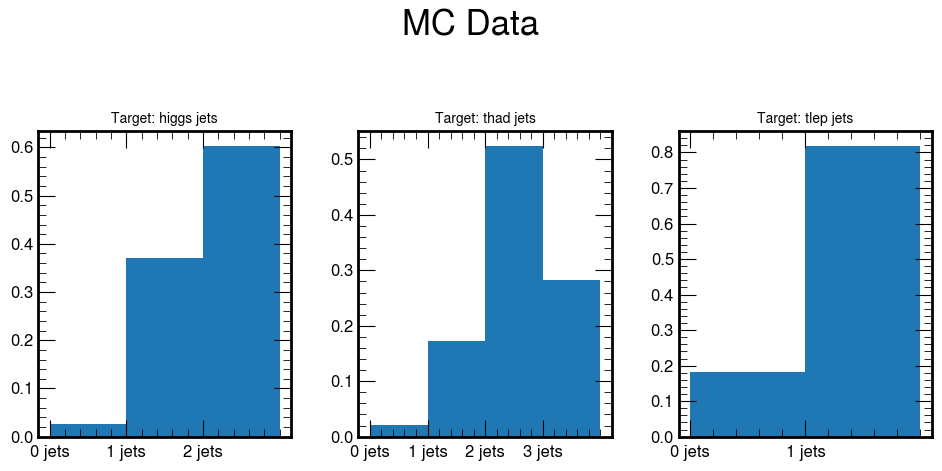

In [29]:
no_bins = [3, 4, 2]
no_plots = 3

fig, ax = plt.subplots(1, no_plots, figsize=(10, 5))
fig.suptitle('MC Data', fontsize=25)

for i, particle in enumerate(list(prov.keys())):
    no_jets_target = get_noJets_assigned2Particle(prov_tensor=prov_tensor_true_train, particle=prov[particle])
    
    _ = ax[i].hist(no_jets_target.numpy(), bins=no_bins[i], range=(0,no_bins[i]), density=True)

    # Set number of ticks for x-axis
    # now, define the ticks (i.e. locations where the labels will be plotted)
    xticks = [j for j in range(no_bins[i])]
    ax[i].set_xticks(xticks)
    
    # also define the labels we'll use (note this MUST have the same size as `xticks`!)
    xtick_labels = [f'{j} jets' for j in range(no_bins[i])]

    # Set ticks labels for x-axis
    ax[i].set_xticklabels(xtick_labels, rotation='horizontal', fontsize=12)
    ax[i].yaxis.set_tick_params(labelsize=12)
    
    ax[i].set_title(f'Target: {particle} jets', fontsize=10)
    
plt.tight_layout()

# Details about the SPANET assignments

# 1. Max Prob

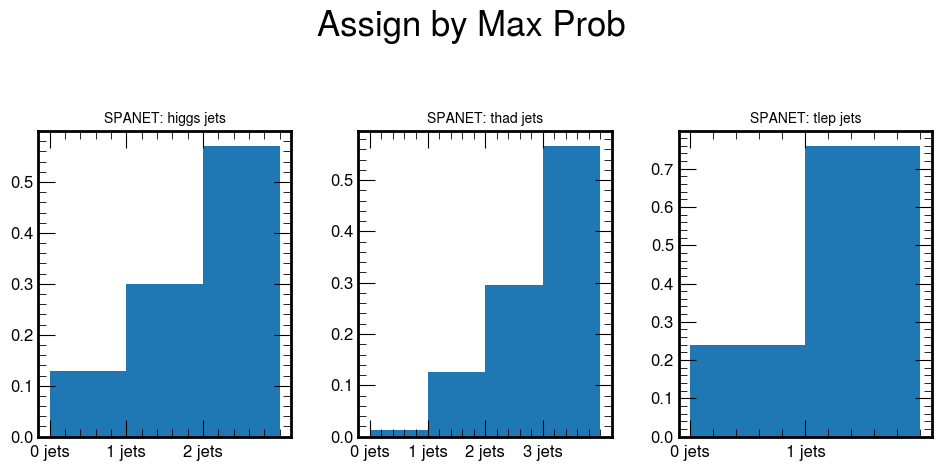

In [15]:
no_bins = [3, 4, 2]
no_plots = 3

fig, ax = plt.subplots(1, no_plots, figsize=(10, 5))
fig.suptitle('Assign by Max Prob', fontsize=25)

for i, particle in enumerate(list(prov.keys())):
    no_jets_target = get_noJets_assigned2Particle(prov_tensor=spanet_prov[:,:16], particle=prov[particle])
    
    _ = ax[i].hist(no_jets_target.numpy(), bins=no_bins[i], range=(0,no_bins[i]), density=True)

    # Set number of ticks for x-axis
    # now, define the ticks (i.e. locations where the labels will be plotted)
    xticks = [j for j in range(no_bins[i])]
    ax[i].set_xticks(xticks)
    
    # also define the labels we'll use (note this MUST have the same size as `xticks`!)
    xtick_labels = [f'{j} jets' for j in range(no_bins[i])]

    # Set ticks labels for x-axis
    ax[i].set_xticklabels(xtick_labels, rotation='horizontal', fontsize=12)
    ax[i].yaxis.set_tick_params(labelsize=12)
    
    ax[i].set_title(f'SPANET: {particle} jets', fontsize=10)
    
plt.tight_layout()

# 2. Higgs assigned first

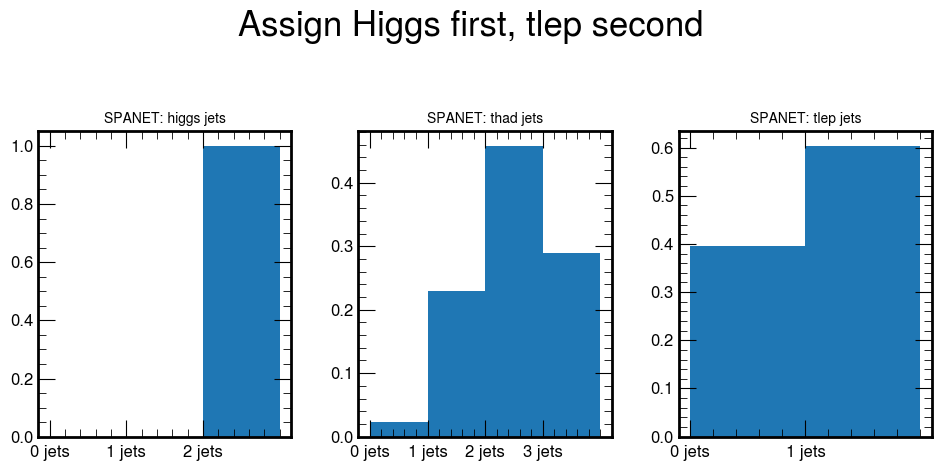

In [16]:
no_bins = [3, 4, 2]
no_plots = 3

fig, ax = plt.subplots(1, no_plots, figsize=(10, 5))
fig.suptitle('Assign Higgs first, tlep second', fontsize=25)

for i, particle in enumerate(list(prov.keys())):
    no_jets_target = get_noJets_assigned2Particle(prov_tensor=spanet_prov_2[:,:16], particle=prov[particle])
    
    _ = ax[i].hist(no_jets_target.numpy(), bins=no_bins[i], range=(0,no_bins[i]), density=True)

    # Set number of ticks for x-axis
    # now, define the ticks (i.e. locations where the labels will be plotted)
    xticks = [j for j in range(no_bins[i])]
    ax[i].set_xticks(xticks)
    
    # also define the labels we'll use (note this MUST have the same size as `xticks`!)
    xtick_labels = [f'{j} jets' for j in range(no_bins[i])]

    # Set ticks labels for x-axis
    ax[i].set_xticklabels(xtick_labels, rotation='horizontal', fontsize=12)
    ax[i].yaxis.set_tick_params(labelsize=12)
    
    ax[i].set_title(f'SPANET: {particle} jets', fontsize=10)
    
plt.tight_layout()

# compare with target prov
# do another method to assign the 2nd higgs if there is one unassigned jet with btag > 0.5

In [17]:
#print(prov_tensor_true_train[0])
print(spanet_prov_2[0])
print(spanet_prov[0])
print(spanet_prov.shape)

tensor([-1.,  3.,  1.,  1.,  2.,  2., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.,  2., -1., -1., -1., -1., -1.])
tensor([-2.,  3.,  2.,  1.,  2.,  2., -2., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1.,  1., -1.])
torch.Size([1612912, 22])


In [18]:
print(spanet_prov.shape)
print(spanet_prov_2.shape)

torch.Size([1612912, 22])
torch.Size([1612912, 22])


# higgs

In [19]:
higgs = prov_tensor_true_train == 1
events_full_higgs = torch.count_nonzero(higgs, dim=1) == 2
events_one_higgs = torch.count_nonzero(higgs, dim=1) == 1
events_zero_higgs = torch.count_nonzero(higgs, dim=1) == 0

print(torch.count_nonzero(events_full_higgs))
print(torch.count_nonzero(events_one_higgs))
print(torch.count_nonzero(events_zero_higgs))

tensor(972926)
tensor(597339)
tensor(42647)


# 1. events_full_higgs

In [20]:
# I don't know why I used this version
# I could get the assignment spanet tensor and target prov tensor and compare them
# for higgs: I compare the both tensors with '1' and then do a "logical_and" between them
# finally i can get the number of non-zero in each event

In [21]:
def get_positions(prov_tensor, ev_indices, particle, no_jets_required):
    no_ev = torch.count_nonzero(ev_indices)
    
    pos = prov_tensor[ev_indices] == particle
    pos = pos.nonzero()
    
    pos_reshaped = torch.reshape(pos, (no_ev, no_jets_required, 2))
    pos_reshaped = pos_reshaped[:,:,1]
    
    return pos_reshaped, pos

In [22]:
target_pos, pos = get_positions(prov_tensor_true_train.squeeze(dim=2), events_full_higgs.squeeze(dim=1),
                                particle=1, no_jets_required=2)

print(prov_tensor_true_train.shape)
print(spanet_prov.shape)
print(spanet_prov_2.shape)

spanet_pos, pos = get_positions(spanet_prov, events_full_higgs.squeeze(dim=1),
                                particle=1, no_jets_required=2)

mask = spanet_pos > 15
spanet_pos[mask] = -1

spanet_pos_2, pos = get_positions(spanet_prov_2, events_full_higgs.squeeze(dim=1),
                                particle=1, no_jets_required=2)

mask = spanet_pos_2 > 15
spanet_pos_2[mask] = -1

print(spanet_pos[0:5])
print(spanet_pos_2[0:5])

torch.Size([1612912, 16, 1])
torch.Size([1612912, 22])
torch.Size([1612912, 22])
tensor([[ 3, -1],
        [ 1, -1],
        [ 2,  5],
        [ 1,  2],
        [ 3, -1]])
tensor([[2, 3],
        [1, 2],
        [2, 5],
        [1, 2],
        [2, 3]])


In [114]:
def getNo_matched_jets_old(spanet_positions, target_positions, no_spanet_assigned_jets, need_permutation=False):
    # X jets assigned -> look at different SPANET events
    check_no_assigned_jets = torch.count_nonzero(spanet_positions != -1, dim=1)
    ev_X_jets_assigned = check_no_assigned_jets == no_spanet_assigned_jets
    
    XJets_spanet_pos = spanet_positions[ev_X_jets_assigned]
    XJets_target_pos = target_positions[ev_X_jets_assigned]
        
    final_result = torch.eq(XJets_spanet_pos, XJets_target_pos).sum(dim=1)
    
    if need_permutation:
        # permute one of the tensors (to consider [0,1] vs [1,2] case -> which should give 1 not 0)
        XJets_target_pos = XJets_target_pos[:,[1,0]]

        second_comparison = torch.eq(XJets_spanet_pos, XJets_target_pos).sum(dim=1)

        final_result = torch.add(final_result, second_comparison)

    return final_result

def getNo_matched_jets(spanet_positions, target_positions, need_permutation=False):
    # X jets assigned -> look at different SPANET events
        
    final_result = torch.eq(spanet_positions, target_positions).sum(dim=1)
    
    if need_permutation:
        # permute one of the tensors (to consider [0,1] vs [1,2] case -> which should give 1 not 0)
        target_positions = target_positions[:,[1,0]]

        second_comparison = torch.eq(spanet_positions, target_positions).sum(dim=1)

        final_result = torch.add(final_result, second_comparison)

    return final_result

def intersect1d_padded(x):
    x, y = np.split(x, 2)
    padded_intersection = -2 * np.ones(x.shape)
    intersection = np.intersect1d(x, y)
    padded_intersection[:intersection.shape[0]] = intersection
    return padded_intersection

def rowwise_intersection(a, b):
    return np.apply_along_axis(intersect1d_padded,
                    1, np.concatenate((a, b), axis=1))



def getNo_matched_jets_intersect(spanet_positions, target_positions):
        
    no_ev = spanet_positions.shape[0]
    spanet_positions = spanet_positions.numpy()
    target_positions = target_positions.numpy()
    
    final_result = rowwise_intersection(spanet_positions, target_positions)
    
    # -1 when I don't have assigned in MC or by SPANET
    # -2 when the assignment is wrong
    check_true = final_result > -0.5
    count_matched = np.count_nonzero((check_true), axis=1)
    
    # -2 when the assignment is wrong
    check_eq_minus2 = final_result == -2
    count_wrong = np.count_nonzero((check_eq_minus2), axis=1)
    
    return count_matched, count_wrong, final_result

In [24]:
count_no_padding, no_matched_jets = getNo_matched_jets_intersect(spanet_positions=spanet_pos[:3], target_positions=target_pos[:3])

print(spanet_pos[:3])
print(target_pos[:3])
print(no_matched_jets)
print(count_no_padding)

tensor([[ 3, -1],
        [ 1, -1],
        [ 2,  5]])
tensor([[3, 6],
        [1, 3],
        [2, 5]])
[[ 3. -1.]
 [ 1. -1.]
 [ 2.  5.]]
[1 1 2]


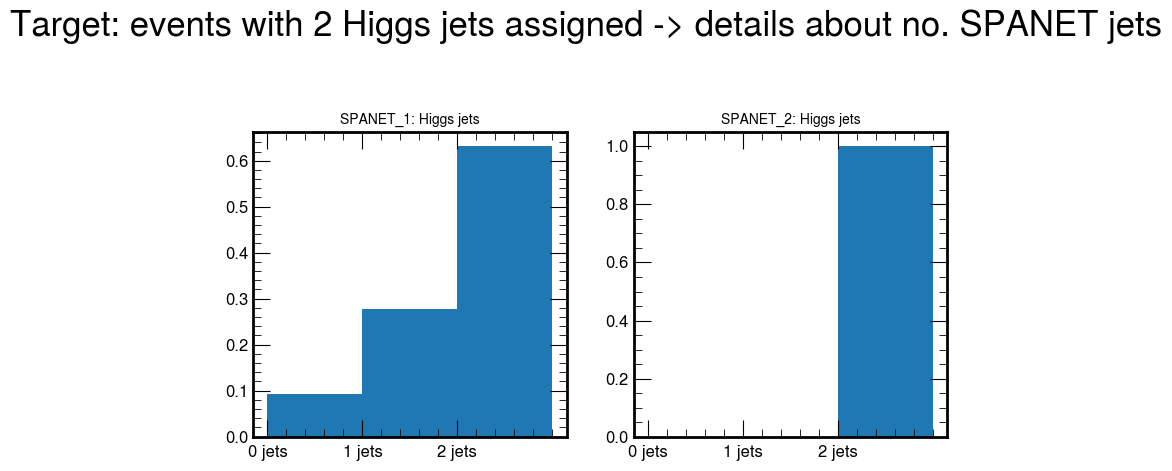

In [25]:
# STATISTICS spanet for target events with 2 Higgs jets
# SPANET VS SPANET_2

no_bins = [3, 3]
no_plots = 2

fig, ax = plt.subplots(1, no_plots, figsize=(8, 5))
fig.suptitle('Target: events with 2 Higgs jets assigned -> details about no. SPANET jets', fontsize=25)

for i in range(no_plots):
    no_jets_target = get_noJets_assigned2Particle(prov_tensor=spanet_prov[events_full_higgs.squeeze(dim=1),:16], particle=prov['higgs'])
    if i == 1:
        no_jets_target = get_noJets_assigned2Particle(prov_tensor=spanet_prov_2[events_full_higgs.squeeze(dim=1),:16], particle=prov['higgs'])
    
    _ = ax[i].hist(no_jets_target.numpy(), bins=no_bins[i], range=(0,no_bins[i]), density=True)

    # Set number of ticks for x-axis
    # now, define the ticks (i.e. locations where the labels will be plotted)
    xticks = [j for j in range(no_bins[i])]
    ax[i].set_xticks(xticks)
    
    # also define the labels we'll use (note this MUST have the same size as `xticks`!)
    xtick_labels = [f'{j} jets' for j in range(no_bins[i])]

    # Set ticks labels for x-axis
    ax[i].set_xticklabels(xtick_labels, rotation='horizontal', fontsize=12)
    ax[i].yaxis.set_tick_params(labelsize=12)
    
    ax[i].set_title(f'SPANET_{i+1}: Higgs jets', fontsize=10)
    
plt.tight_layout()

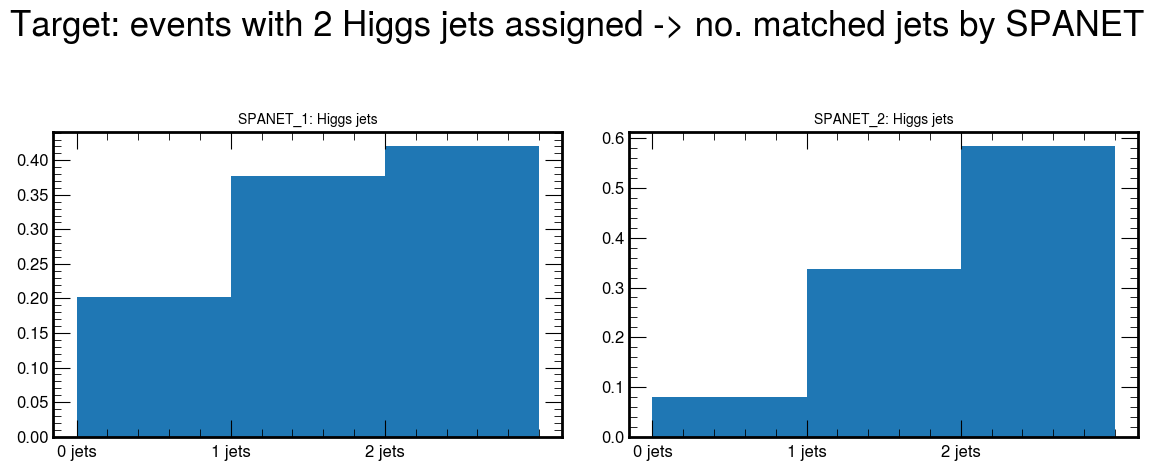

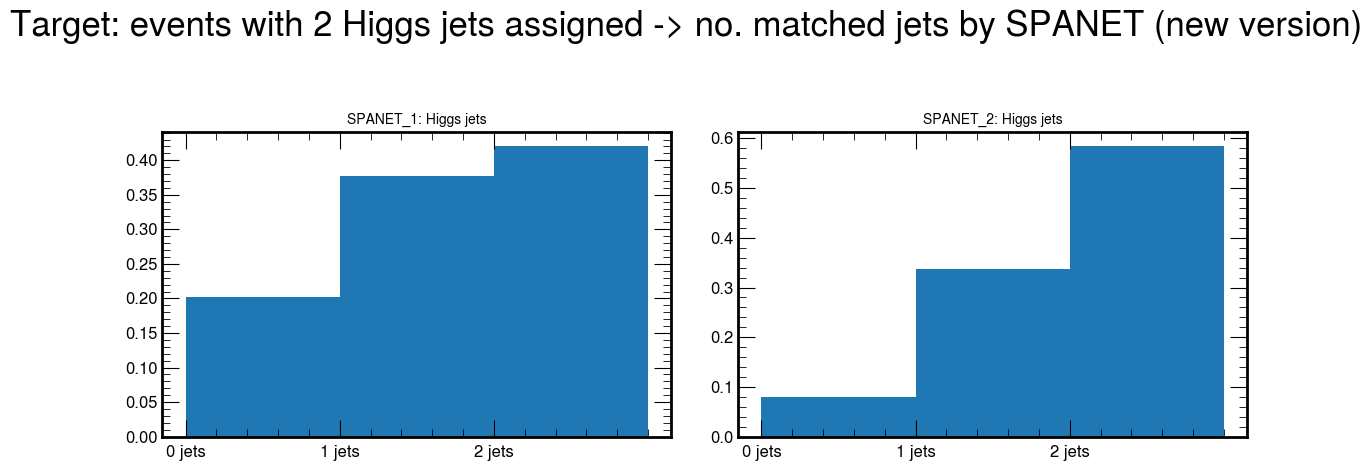

In [26]:
# 2 jets assigned

# SPANET VS SPANET_2:

no_bins = [3, 3, 3]
no_plots = 2

fig, ax = plt.subplots(1, no_plots, figsize=(12, 5))
fig.suptitle('Target: events with 2 Higgs jets assigned -> no. matched jets by SPANET', fontsize=25)

for i in range(no_plots):
    if i == 0:
        # SPANET: 2 jets assigned
        no_matched_jets = getNo_matched_jets(spanet_positions=spanet_pos, target_positions=target_pos, need_permutation=True)
    else:
        # SPANET_2: 2 jets assigned
        no_matched_jets = getNo_matched_jets(spanet_positions=spanet_pos_2, target_positions=target_pos, need_permutation=True)
    
    _ = ax[i].hist(no_matched_jets.numpy(), bins=no_bins[i], range=(0,no_bins[i]), density=True)

    # Set number of ticks for x-axis
    # now, define the ticks (i.e. locations where the labels will be plotted)
    xticks = [j for j in range(no_bins[i])]
    ax[i].set_xticks(xticks)
    
    # also define the labels we'll use (note this MUST have the same size as `xticks`!)
    xtick_labels = [f'{j} jets' for j in range(no_bins[i])]

    # Set ticks labels for x-axis
    ax[i].set_xticklabels(xtick_labels, rotation='horizontal', fontsize=12)
    ax[i].yaxis.set_tick_params(labelsize=12)
    
    ax[i].set_title(f'SPANET_{i+1}: Higgs jets', fontsize=10)
    
plt.tight_layout()

# 2 jets assigned

# SPANET VS SPANET_2:

no_bins = [3, 3, 3]
no_plots = 2

fig, ax = plt.subplots(1, no_plots, figsize=(12, 5))
fig.suptitle('Target: events with 2 Higgs jets assigned -> no. matched jets by SPANET (new version)', fontsize=25)

for i in range(no_plots):
    if i == 0:
        # SPANET: 2 jets assigned
        count_no_padding, no_matched_jets = getNo_matched_jets_intersect(spanet_positions=spanet_pos, target_positions=target_pos)
    else:
        # SPANET_2: 2 jets assigned
        count_no_padding, no_matched_jets = getNo_matched_jets_intersect(spanet_positions=spanet_pos_2, target_positions=target_pos)
    
    _ = ax[i].hist(count_no_padding, bins=no_bins[i], range=(0,no_bins[i]), density=True)

    # Set number of ticks for x-axis
    # now, define the ticks (i.e. locations where the labels will be plotted)
    xticks = [j for j in range(no_bins[i])]
    ax[i].set_xticks(xticks)
    
    # also define the labels we'll use (note this MUST have the same size as `xticks`!)
    xtick_labels = [f'{j} jets' for j in range(no_bins[i])]

    # Set ticks labels for x-axis
    ax[i].set_xticklabels(xtick_labels, rotation='horizontal', fontsize=12)
    ax[i].yaxis.set_tick_params(labelsize=12)
    
    ax[i].set_title(f'SPANET_{i+1}: Higgs jets', fontsize=10)
    
plt.tight_layout()

# 2. events_one_higgs

In [27]:
target_pos, pos = get_positions(prov_tensor_true_train.squeeze(dim=2), events_one_higgs.squeeze(dim=1),
                                particle=1, no_jets_required=1)

print(prov_tensor_true_train.shape)
print(spanet_prov.shape)
print(spanet_prov_2.shape)

spanet_pos, pos = get_positions(spanet_prov, events_one_higgs.squeeze(dim=1),
                                particle=1, no_jets_required=2)

mask = spanet_pos > 15
spanet_pos[mask] = -1

spanet_pos_2, pos = get_positions(spanet_prov_2, events_one_higgs.squeeze(dim=1),
                                particle=1, no_jets_required=2)

mask = spanet_pos_2 > 15
spanet_pos_2[mask] = -1

print(spanet_pos[0:5])
print(spanet_pos_2[0:5])

torch.Size([1612912, 16, 1])
torch.Size([1612912, 22])
torch.Size([1612912, 22])
tensor([[ 5, -1],
        [-1, -1],
        [ 1,  2],
        [ 5, -1],
        [ 2,  5]])
tensor([[0, 5],
        [1, 2],
        [1, 2],
        [1, 5],
        [2, 5]])


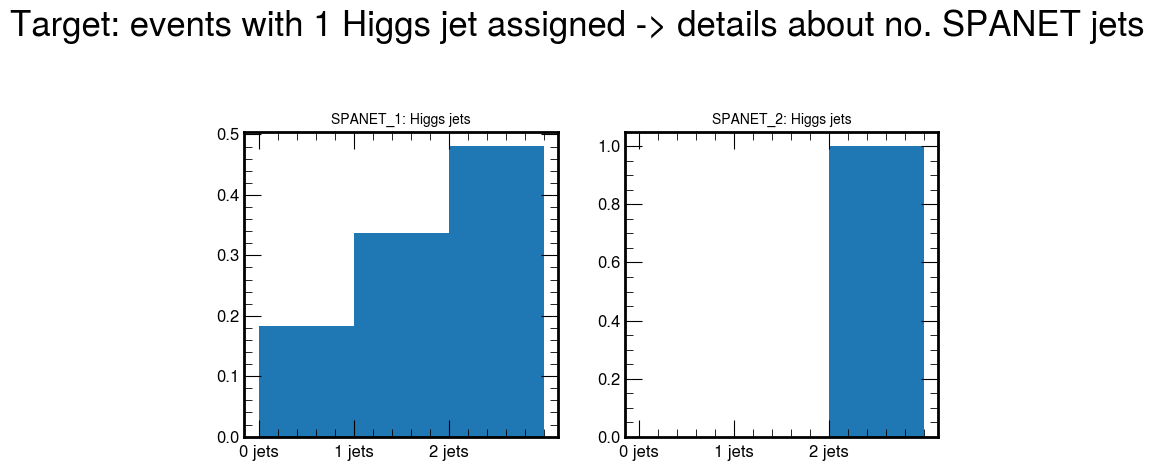

In [28]:
# STATISTICS spanet for target events with 2 Higgs jets
# SPANET VS SPANET_2

no_bins = [3, 3]
no_plots = 2

fig, ax = plt.subplots(1, no_plots, figsize=(8, 5))
fig.suptitle('Target: events with 1 Higgs jet assigned -> details about no. SPANET jets', fontsize=25)

for i in range(no_plots):
    no_jets_target = get_noJets_assigned2Particle(prov_tensor=spanet_prov[events_one_higgs.squeeze(dim=1),:16], particle=prov['higgs'])
    if i == 1:
        no_jets_target = get_noJets_assigned2Particle(prov_tensor=spanet_prov_2[events_one_higgs.squeeze(dim=1),:16], particle=prov['higgs'])
    
    _ = ax[i].hist(no_jets_target.numpy(), bins=no_bins[i], range=(0,no_bins[i]), density=True)

    # Set number of ticks for x-axis
    # now, define the ticks (i.e. locations where the labels will be plotted)
    xticks = [j for j in range(no_bins[i])]
    ax[i].set_xticks(xticks)
    
    # also define the labels we'll use (note this MUST have the same size as `xticks`!)
    xtick_labels = [f'{j} jets' for j in range(no_bins[i])]

    # Set ticks labels for x-axis
    ax[i].set_xticklabels(xtick_labels, rotation='horizontal', fontsize=12)
    ax[i].yaxis.set_tick_params(labelsize=12)
    
    ax[i].set_title(f'SPANET_{i+1}: Higgs jets', fontsize=10)
    
plt.tight_layout()

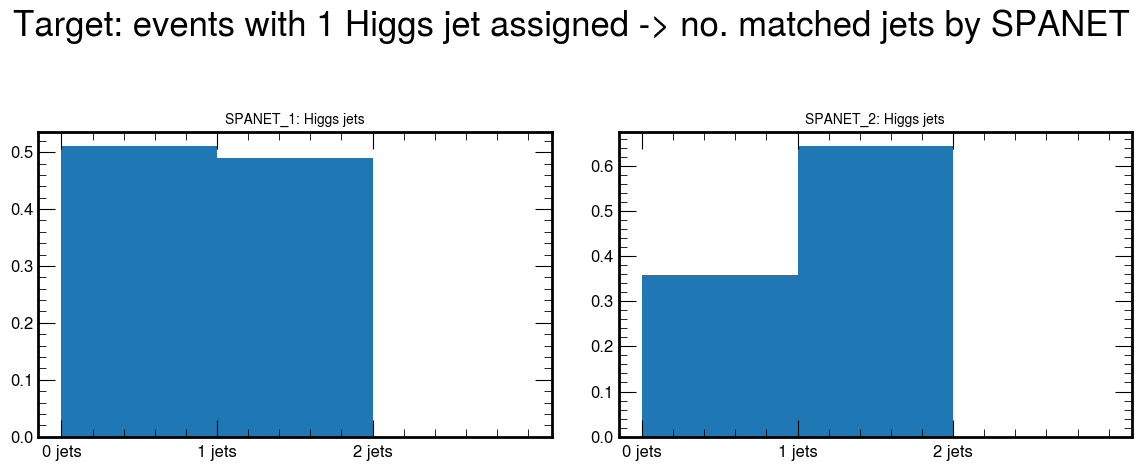

In [29]:
# 2 jets assigned

# SPANET VS SPANET_2:

no_bins = [3, 3, 3]
no_plots = 2

fig, ax = plt.subplots(1, no_plots, figsize=(12, 5))
fig.suptitle('Target: events with 1 Higgs jet assigned -> no. matched jets by SPANET', fontsize=25)

for i in range(no_plots):
    if i == 0:
        no_matched_jets = getNo_matched_jets(spanet_positions=spanet_pos, target_positions=target_pos, need_permutation=False)
    else:
        no_matched_jets = getNo_matched_jets(spanet_positions=spanet_pos_2, target_positions=target_pos, need_permutation=False)
    
    _ = ax[i].hist(no_matched_jets.numpy(), bins=no_bins[i], range=(0,no_bins[i]), density=True)

    # Set number of ticks for x-axis
    # now, define the ticks (i.e. locations where the labels will be plotted)
    xticks = [j for j in range(no_bins[i])]
    ax[i].set_xticks(xticks)
    
    # also define the labels we'll use (note this MUST have the same size as `xticks`!)
    xtick_labels = [f'{j} jets' for j in range(no_bins[i])]

    # Set ticks labels for x-axis
    ax[i].set_xticklabels(xtick_labels, rotation='horizontal', fontsize=12)
    ax[i].yaxis.set_tick_params(labelsize=12)
    
    ax[i].set_title(f'SPANET_{i+1}: Higgs jets', fontsize=10)
    
plt.tight_layout()

# 3. events_zero_higgs

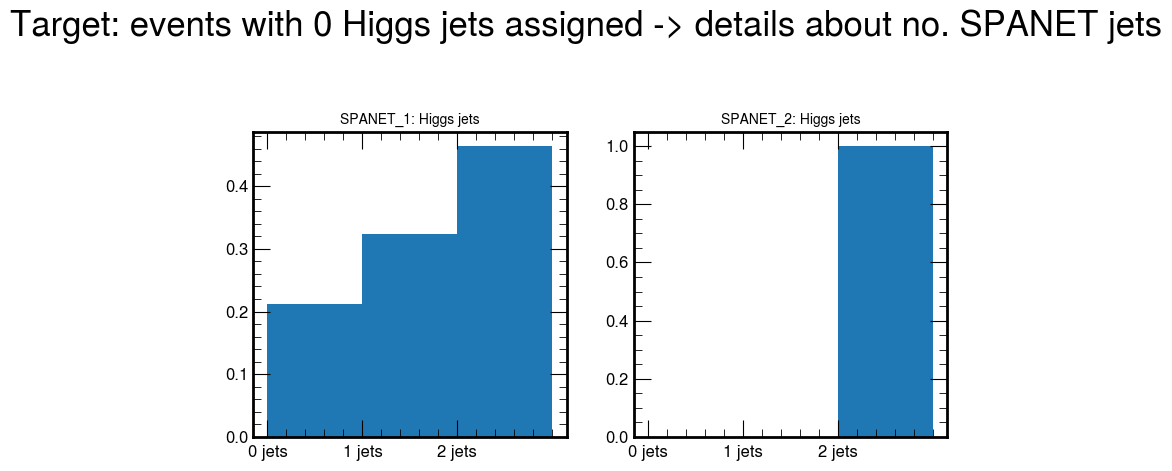

In [30]:
# STATISTICS spanet for target events with 2 Higgs jets
# SPANET VS SPANET_2

no_bins = [3, 3]
no_plots = 2

fig, ax = plt.subplots(1, no_plots, figsize=(8, 5))
fig.suptitle('Target: events with 0 Higgs jets assigned -> details about no. SPANET jets', fontsize=25)

for i in range(no_plots):
    no_jets_target = get_noJets_assigned2Particle(prov_tensor=spanet_prov[events_zero_higgs.squeeze(dim=1),:16], particle=prov['higgs'])
    if i == 1:
        no_jets_target = get_noJets_assigned2Particle(prov_tensor=spanet_prov_2[events_zero_higgs.squeeze(dim=1),:16], particle=prov['higgs'])
    
    _ = ax[i].hist(no_jets_target.numpy(), bins=no_bins[i], range=(0,no_bins[i]), density=True)

    # Set number of ticks for x-axis
    # now, define the ticks (i.e. locations where the labels will be plotted)
    xticks = [j for j in range(no_bins[i])]
    ax[i].set_xticks(xticks)
    
    # also define the labels we'll use (note this MUST have the same size as `xticks`!)
    xtick_labels = [f'{j} jets' for j in range(no_bins[i])]

    # Set ticks labels for x-axis
    ax[i].set_xticklabels(xtick_labels, rotation='horizontal', fontsize=12)
    ax[i].yaxis.set_tick_params(labelsize=12)
    
    ax[i].set_title(f'SPANET_{i+1}: Higgs jets', fontsize=10)
    
plt.tight_layout()

# higgs inclusive events

In [119]:
higgs = prov_tensor_true_train == 1
events_full_higgs = torch.count_nonzero(higgs, dim=1) == 2
events_one_higgs = torch.count_nonzero(higgs, dim=1) == 1
events_zero_higgs = torch.count_nonzero(higgs, dim=1) == 0

print(torch.count_nonzero(events_full_higgs))
print(torch.count_nonzero(events_one_higgs))
print(torch.count_nonzero(events_zero_higgs))

tensor(972926)
tensor(597339)
tensor(42647)


In [120]:
higgs_prov_tensor_true_train = torch.clone(prov_tensor_true_train).squeeze(dim=2)
x = torch.ones((higgs_prov_tensor_true_train.shape[0], 2)) * -1
higgs_prov_tensor_true_train = torch.cat((higgs_prov_tensor_true_train, x), dim=1)
print(higgs_prov_tensor_true_train.shape)
print(events_one_higgs.shape)

higgs_prov_tensor_true_train[events_one_higgs.squeeze(dim=1), -2] = 1
higgs_prov_tensor_true_train[events_zero_higgs.squeeze(dim=1), -2] = 1
higgs_prov_tensor_true_train[events_zero_higgs.squeeze(dim=1), -1] = 1

torch.Size([1612912, 18])
torch.Size([1612912, 1])


In [121]:
full_ev = torch.ones(higgs_prov_tensor_true_train.shape[0], dtype=torch.bool)

target_pos, pos = get_positions(higgs_prov_tensor_true_train, full_ev,
                                particle=1, no_jets_required=2)

mask = target_pos > 15
target_pos[mask] = -1

spanet_pos, pos = get_positions(spanet_prov, full_ev,
                                particle=1, no_jets_required=2)

mask = spanet_pos > 15
spanet_pos[mask] = -1

spanet_pos_2, pos = get_positions(spanet_prov_2, full_ev,
                                particle=1, no_jets_required=2)

mask = spanet_pos_2 > 15
spanet_pos_2[mask] = -1

print(target_pos[0:5])
print(spanet_pos[0:5])
print(spanet_pos_2[0:5])

tensor([[ 3,  6],
        [ 1,  3],
        [ 2,  5],
        [ 1,  2],
        [ 0, -1]])
tensor([[ 3, -1],
        [ 1, -1],
        [ 2,  5],
        [ 1,  2],
        [ 5, -1]])
tensor([[2, 3],
        [1, 2],
        [2, 5],
        [1, 2],
        [0, 5]])


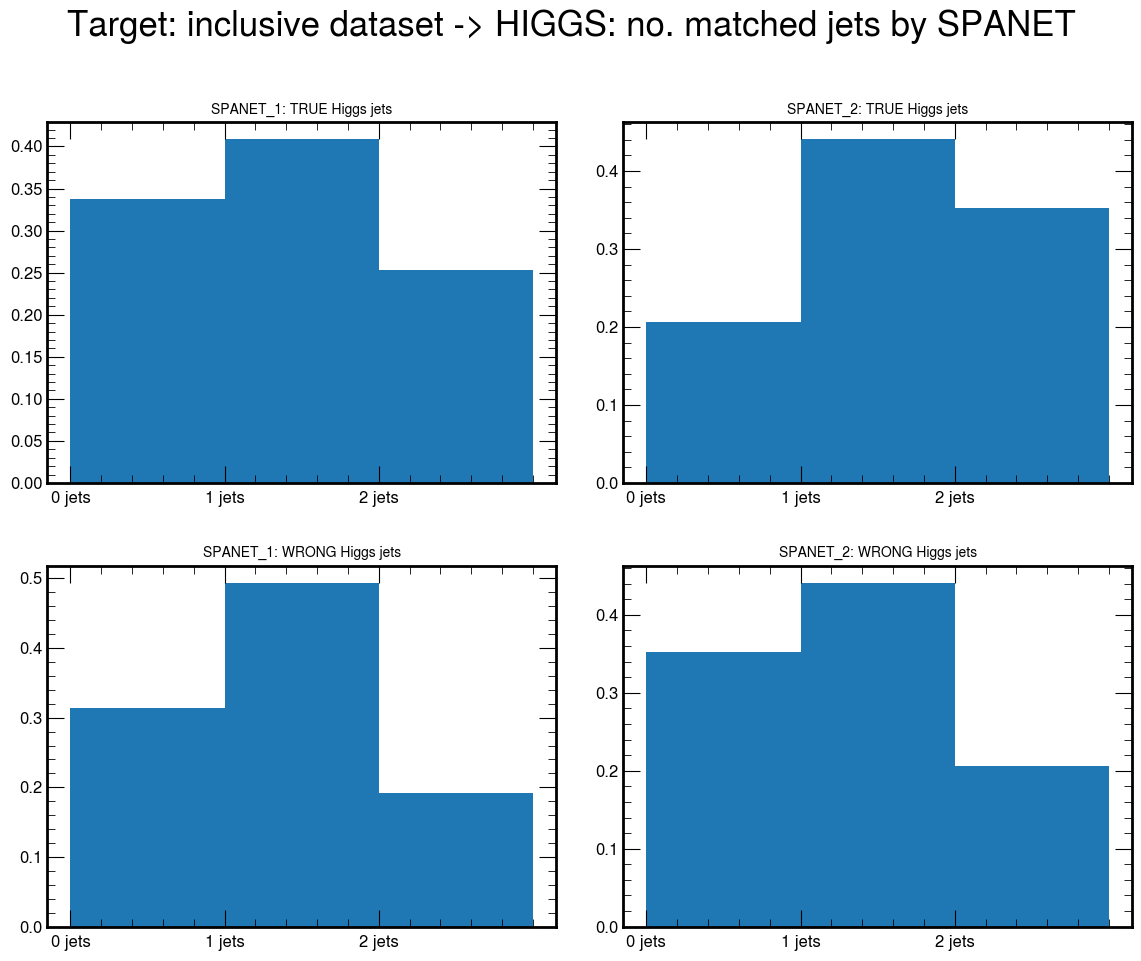

In [122]:
# Inclusive dataset

# SPANET VS SPANET_2:

no_bins = [3, 3]
no_plots = 2

fig, ax = plt.subplots(2, no_plots, figsize=(12, 10))
fig.suptitle('Target: inclusive dataset -> HIGGS: no. matched jets by SPANET', fontsize=25)

for i in range(no_plots):
    if i == 0:
        no_matched_jets, count_wrong, pos = getNo_matched_jets_intersect(spanet_positions=spanet_pos, target_positions=target_pos)
    else:
        no_matched_jets, count_wrong, pos = getNo_matched_jets_intersect(spanet_positions=spanet_pos_2, target_positions=target_pos)
    
    _ = ax[0,i].hist(no_matched_jets, bins=no_bins[i], range=(0,no_bins[i]), density=True)
    _ = ax[1,i].hist(count_wrong, bins=no_bins[i], range=(0,no_bins[i]), density=True)

    # Set number of ticks for x-axis
    # now, define the ticks (i.e. locations where the labels will be plotted)
    xticks = [j for j in range(no_bins[i])]
    ax[0,i].set_xticks(xticks)
    ax[1,i].set_xticks(xticks)
    
    # also define the labels we'll use (note this MUST have the same size as `xticks`!)
    xtick_labels = [f'{j} jets' for j in range(no_bins[i])]

    # Set ticks labels for x-axis
    ax[0,i].set_xticklabels(xtick_labels, rotation='horizontal', fontsize=12)
    ax[0,i].yaxis.set_tick_params(labelsize=12)
    ax[1,i].set_xticklabels(xtick_labels, rotation='horizontal', fontsize=12)
    ax[1,i].yaxis.set_tick_params(labelsize=12)
    
    ax[0,i].set_title(f'SPANET_{i+1}: TRUE Higgs jets', fontsize=10)
    ax[1,i].set_title(f'SPANET_{i+1}: WRONG Higgs jets', fontsize=10)
    
plt.tight_layout()

# top leptonic analysis:

In [164]:
tlep = prov_tensor_true_train == prov['tlep']
events_full_tlep = torch.count_nonzero(tlep, dim=1) == 2
events_one_tlep = torch.count_nonzero(tlep, dim=1) == 1
events_zero_tlep = torch.count_nonzero(tlep, dim=1) == 0

print(torch.count_nonzero(events_full_tlep))
print(torch.count_nonzero(events_one_tlep))
print(torch.count_nonzero(events_zero_tlep))

tensor(0)
tensor(1320244)
tensor(292668)


# target: one tlep

In [165]:
target_pos, pos = get_positions(prov_tensor_true_train.squeeze(dim=2), events_one_tlep.squeeze(dim=1),
                                particle=prov['tlep'], no_jets_required=1)

print(prov_tensor_true_train.shape)
print(spanet_prov.shape)
print(spanet_prov_2.shape)

spanet_pos, pos = get_positions(spanet_prov, events_one_tlep.squeeze(dim=1),
                                particle=prov['tlep'], no_jets_required=1)

mask = spanet_pos > 15
spanet_pos[mask] = -1

spanet_pos_2, pos = get_positions(spanet_prov_2, events_one_tlep.squeeze(dim=1),
                                particle=prov['tlep'], no_jets_required=1)

mask = spanet_pos_2 > 15
spanet_pos_2[mask] = -1

print(spanet_pos[0:5])
print(spanet_pos_2[0:5])

torch.Size([1612912, 16, 1])
torch.Size([1612912, 22])
torch.Size([1612912, 22])
tensor([[ 1],
        [ 3],
        [-1],
        [ 0],
        [ 3]])
tensor([[ 1],
        [ 3],
        [-1],
        [-1],
        [ 3]])


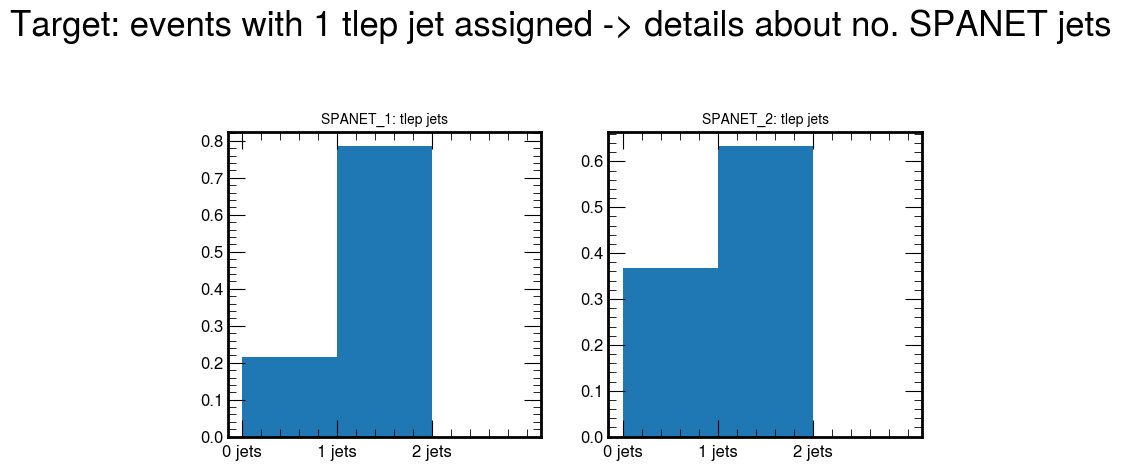

In [166]:
# STATISTICS spanet for target events with 2 Higgs jets
# SPANET VS SPANET_2

no_bins = [3, 3]
no_plots = 2

fig, ax = plt.subplots(1, no_plots, figsize=(8, 5))
fig.suptitle('Target: events with 1 tlep jet assigned -> details about no. SPANET jets', fontsize=25)

for i in range(no_plots):
    no_jets_target = get_noJets_assigned2Particle(prov_tensor=spanet_prov[events_one_tlep.squeeze(dim=1),:16], particle=prov['tlep'])
    if i == 1:
        no_jets_target = get_noJets_assigned2Particle(prov_tensor=spanet_prov_2[events_one_tlep.squeeze(dim=1),:16], particle=prov['tlep'])
    
    _ = ax[i].hist(no_jets_target.numpy(), bins=no_bins[i], range=(0,no_bins[i]), density=True)

    # Set number of ticks for x-axis
    # now, define the ticks (i.e. locations where the labels will be plotted)
    xticks = [j for j in range(no_bins[i])]
    ax[i].set_xticks(xticks)
    
    # also define the labels we'll use (note this MUST have the same size as `xticks`!)
    xtick_labels = [f'{j} jets' for j in range(no_bins[i])]

    # Set ticks labels for x-axis
    ax[i].set_xticklabels(xtick_labels, rotation='horizontal', fontsize=12)
    ax[i].yaxis.set_tick_params(labelsize=12)
    
    ax[i].set_title(f'SPANET_{i+1}: tlep jets', fontsize=10)
    
plt.tight_layout()

2


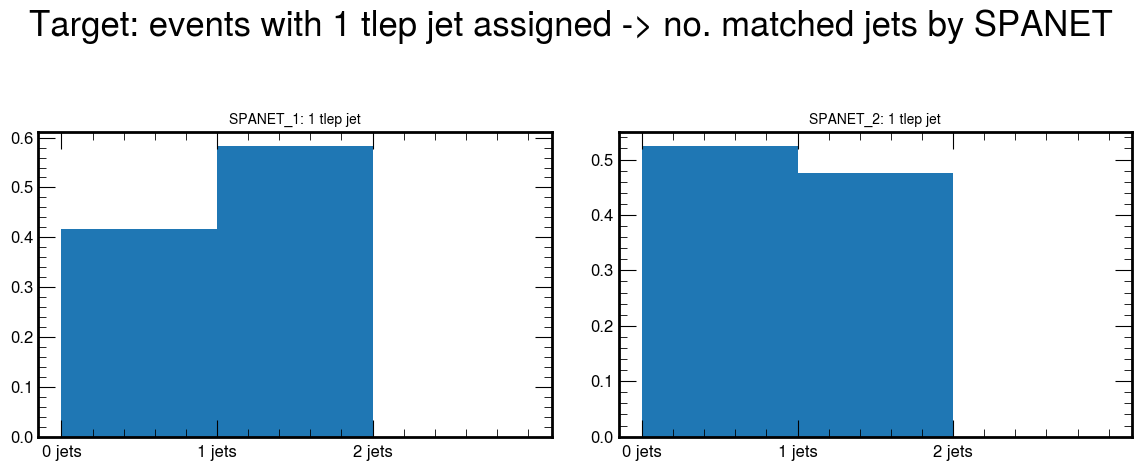

In [168]:
# SPANET VS SPANET_2:

no_bins = [3, 3]
no_plots = 2

fig, ax = plt.subplots(1, no_plots, figsize=(12, 5))
fig.suptitle('Target: events with 1 tlep jet assigned -> no. matched jets by SPANET', fontsize=25)

for i in range(no_plots):
    if i == 0:
        # SPANET: 1 jet assigned
        no_matched_jets = getNo_matched_jets(spanet_positions=spanet_pos, target_positions=target_pos, need_permutation=False)
        j = 1
    else:
        # SPANET_2: 1 jet assigned
        print('2')
        no_matched_jets = getNo_matched_jets(spanet_positions=spanet_pos_2, target_positions=target_pos, need_permutation=False)
        j = 2
    
    _ = ax[i].hist(no_matched_jets.numpy(), bins=no_bins[i], range=(0,no_bins[i]), density=True)

    # Set number of ticks for x-axis
    # now, define the ticks (i.e. locations where the labels will be plotted)
    xticks = [j for j in range(no_bins[i])]
    ax[i].set_xticks(xticks)
    
    # also define the labels we'll use (note this MUST have the same size as `xticks`!)
    xtick_labels = [f'{j} jets' for j in range(no_bins[i])]

    # Set ticks labels for x-axis
    ax[i].set_xticklabels(xtick_labels, rotation='horizontal', fontsize=12)
    ax[i].yaxis.set_tick_params(labelsize=12)
    
    ax[i].set_title(f'SPANET_{j}: 1 tlep jet', fontsize=10)
    
plt.tight_layout()

# target: zero tlep

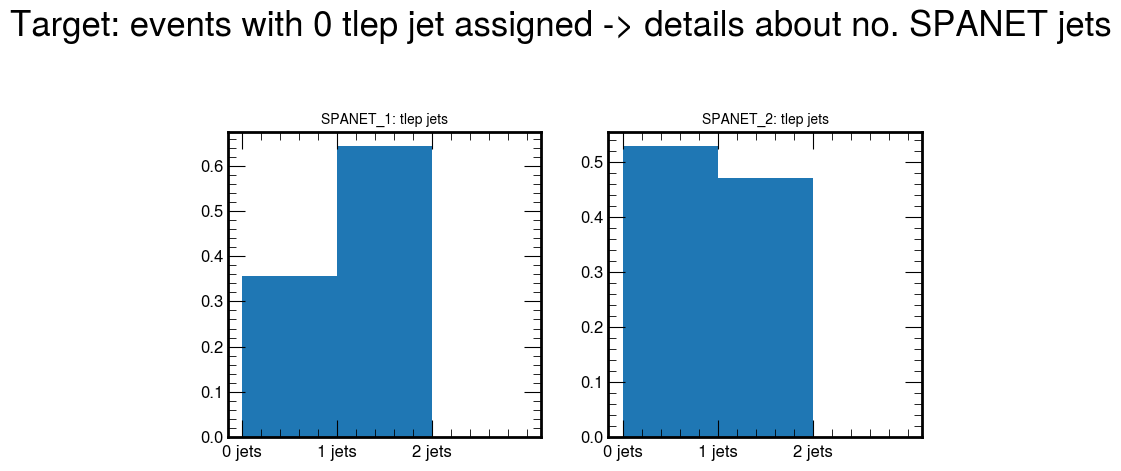

In [169]:
# STATISTICS spanet for target events with 2 Higgs jets
# SPANET VS SPANET_2

no_bins = [3, 3]
no_plots = 2

fig, ax = plt.subplots(1, no_plots, figsize=(8, 5))
fig.suptitle('Target: events with 0 tlep jet assigned -> details about no. SPANET jets', fontsize=25)

for i in range(no_plots):
    no_jets_target = get_noJets_assigned2Particle(prov_tensor=spanet_prov[events_zero_tlep.squeeze(dim=1),:16], particle=prov['tlep'])
    if i == 1:
        no_jets_target = get_noJets_assigned2Particle(prov_tensor=spanet_prov_2[events_zero_tlep.squeeze(dim=1),:16], particle=prov['tlep'])
    
    _ = ax[i].hist(no_jets_target.numpy(), bins=no_bins[i], range=(0,no_bins[i]), density=True)

    # Set number of ticks for x-axis
    # now, define the ticks (i.e. locations where the labels will be plotted)
    xticks = [j for j in range(no_bins[i])]
    ax[i].set_xticks(xticks)
    
    # also define the labels we'll use (note this MUST have the same size as `xticks`!)
    xtick_labels = [f'{j} jets' for j in range(no_bins[i])]

    # Set ticks labels for x-axis
    ax[i].set_xticklabels(xtick_labels, rotation='horizontal', fontsize=12)
    ax[i].yaxis.set_tick_params(labelsize=12)
    
    ax[i].set_title(f'SPANET_{i+1}: tlep jets', fontsize=10)
    
plt.tight_layout()

# INCLUSIVE DATASET TLEP

In [123]:
tlep = prov_tensor_true_train == prov['tlep']
events_full_tlep = torch.count_nonzero(tlep, dim=1) == 2
events_one_tlep = torch.count_nonzero(tlep, dim=1) == 1
events_zero_tlep = torch.count_nonzero(tlep, dim=1) == 0

print(torch.count_nonzero(events_full_tlep))
print(torch.count_nonzero(events_one_tlep))
print(torch.count_nonzero(events_zero_tlep))

tensor(0)
tensor(1320244)
tensor(292668)


In [124]:
tlep_prov_tensor_true_train = torch.clone(prov_tensor_true_train).squeeze(dim=2)
x = torch.ones((tlep_prov_tensor_true_train.shape[0], 1)) * -1
tlep_prov_tensor_true_train = torch.cat((tlep_prov_tensor_true_train, x), dim=1)
print(tlep_prov_tensor_true_train.shape)
print(events_one_tlep.shape)

tlep_prov_tensor_true_train[events_zero_tlep.squeeze(dim=1), -1] = prov['tlep']

torch.Size([1612912, 17])
torch.Size([1612912, 1])


In [125]:
full_ev = torch.ones(tlep_prov_tensor_true_train.shape[0], dtype=torch.bool)

target_pos, pos = get_positions(tlep_prov_tensor_true_train, full_ev, particle=prov['tlep'], no_jets_required=1)

mask = target_pos > 15
target_pos[mask] = -1

spanet_pos, pos = get_positions(spanet_prov, full_ev,
                                particle=prov['tlep'], no_jets_required=1)

mask = spanet_pos > 15
spanet_pos[mask] = -1

spanet_pos_2, pos = get_positions(spanet_prov_2, full_ev,
                                particle=prov['tlep'], no_jets_required=1)

mask = spanet_pos_2 > 15
spanet_pos_2[mask] = -1

print(target_pos[0:5])
print(spanet_pos[0:5])
print(spanet_pos_2[0:5])

tensor([[ 1],
        [-1],
        [ 3],
        [ 4],
        [ 5]])
tensor([[ 1],
        [ 2],
        [ 3],
        [-1],
        [ 0]])
tensor([[ 1],
        [-1],
        [ 3],
        [-1],
        [-1]])


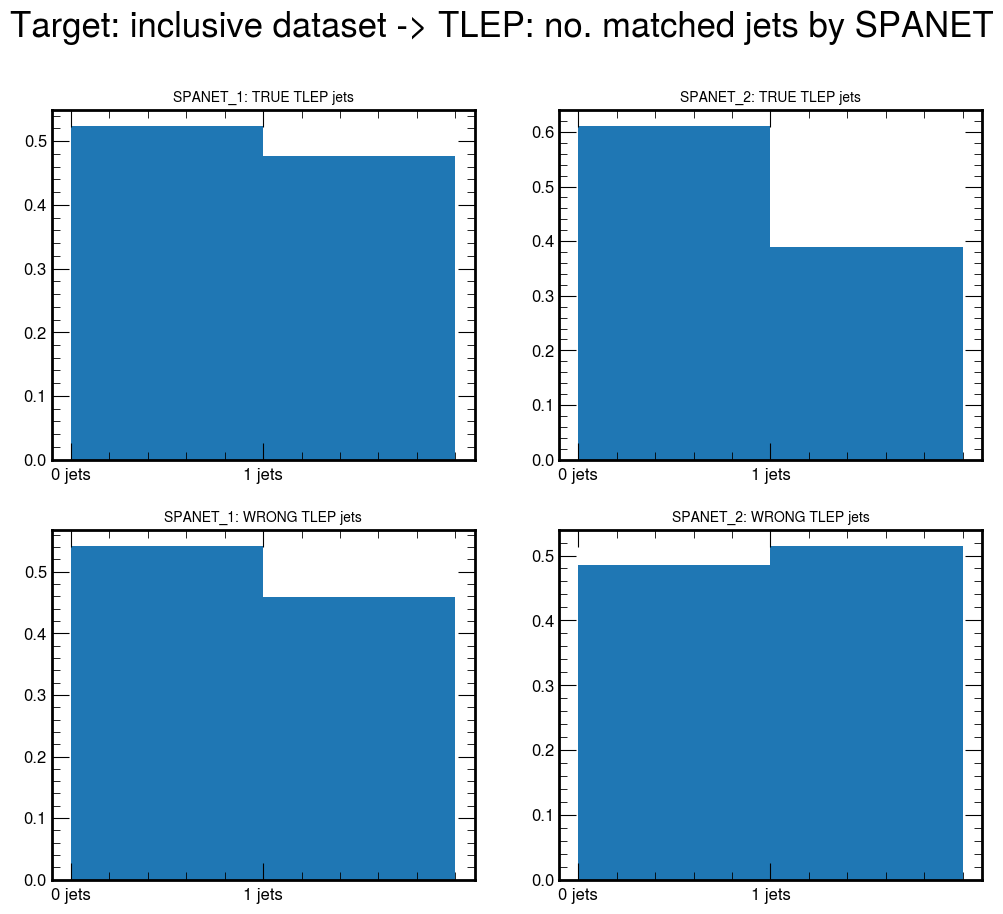

In [127]:
# Inclusive dataset

# SPANET VS SPANET_2:

no_bins = [2, 2]
no_plots = 2

fig, ax = plt.subplots(2, no_plots, figsize=(12, 10))
fig.suptitle('Target: inclusive dataset -> TLEP: no. matched jets by SPANET', fontsize=25)

for i in range(no_plots):
    if i == 0:
        no_matched_jets, count_wrong, pos = getNo_matched_jets_intersect(spanet_positions=spanet_pos, target_positions=target_pos)
    else:
        no_matched_jets, count_wrong, pos = getNo_matched_jets_intersect(spanet_positions=spanet_pos_2, target_positions=target_pos)
    
    _ = ax[0,i].hist(no_matched_jets, bins=no_bins[i], range=(0,no_bins[i]), density=True)  
    _ = ax[1,i].hist(count_wrong, bins=no_bins[i], range=(0,no_bins[i]), density=True)  

    # Set number of ticks for x-axis
    # now, define the ticks (i.e. locations where the labels will be plotted)
    xticks = [j for j in range(no_bins[i])]
    ax[0,i].set_xticks(xticks)
    ax[1,i].set_xticks(xticks)
    
    # also define the labels we'll use (note this MUST have the same size as `xticks`!)
    xtick_labels = [f'{j} jets' for j in range(no_bins[i])]

    # Set ticks labels for x-axis
    ax[0,i].set_xticklabels(xtick_labels, rotation='horizontal', fontsize=12)
    ax[0,i].yaxis.set_tick_params(labelsize=12)
    ax[1,i].set_xticklabels(xtick_labels, rotation='horizontal', fontsize=12)
    ax[1,i].yaxis.set_tick_params(labelsize=12)
    
    ax[0,i].set_title(f'SPANET_{i+1}: TRUE TLEP jets', fontsize=10)
    ax[1,i].set_title(f'SPANET_{i+1}: WRONG TLEP jets', fontsize=10)
    


# top hadronic

In [215]:
thad = prov_tensor_true_train == prov['thad']
events_full_thad = torch.count_nonzero(thad, dim=1) == 3
events_two_thad = torch.count_nonzero(thad, dim=1) == 2
events_one_thad = torch.count_nonzero(thad, dim=1) == 1
events_zero_thad = torch.count_nonzero(thad, dim=1) == 0

print(torch.count_nonzero(events_full_thad))
print(torch.count_nonzero(events_two_thad))
print(torch.count_nonzero(events_one_thad))
print(torch.count_nonzero(events_zero_thad))

tensor(455463)
tensor(845910)
tensor(278781)
tensor(32758)


# 3 thad jets

In [216]:
target_pos, pos = get_positions(prov_tensor_true_train.squeeze(dim=2), events_full_thad.squeeze(dim=1),
                                particle=prov['thad'], no_jets_required=3)

print(prov_tensor_true_train.shape)
print(spanet_prov.shape)
print(spanet_prov_2.shape)

spanet_pos, pos = get_positions(spanet_prov, events_full_thad.squeeze(dim=1),
                                particle=prov['thad'], no_jets_required=3)

mask = spanet_pos > 15
spanet_pos[mask] = -1

spanet_pos_2, pos = get_positions(spanet_prov_2, events_full_thad.squeeze(dim=1),
                                particle=prov['thad'], no_jets_required=3)

mask = spanet_pos_2 > 15
spanet_pos_2[mask] = -1

print(spanet_pos[0:5])
print(spanet_pos_2[0:5])

torch.Size([1612912, 16, 1])
torch.Size([1612912, 22])
torch.Size([1612912, 22])
tensor([[ 2,  4,  5],
        [ 0,  3,  4],
        [ 0,  2,  3],
        [ 1,  3,  7],
        [ 5,  6, -1]])
tensor([[ 4,  5, -1],
        [ 0,  3,  4],
        [ 0,  2,  3],
        [ 1,  7, -1],
        [ 5,  6, -1]])


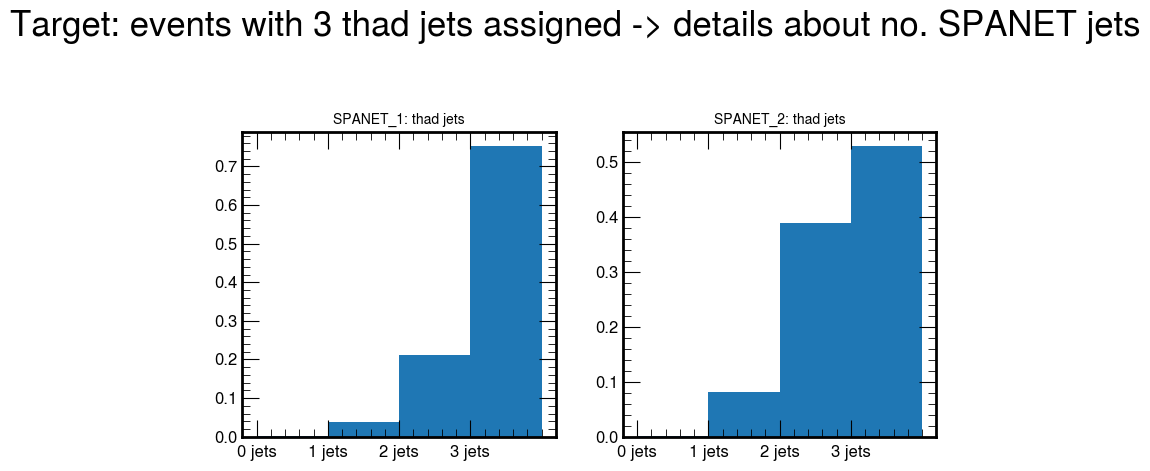

In [217]:
# STATISTICS spanet for target events with 2 Higgs jets
# SPANET VS SPANET_2

no_bins = [4, 4]
no_plots = 2

fig, ax = plt.subplots(1, no_plots, figsize=(8, 5))
fig.suptitle('Target: events with 3 thad jets assigned -> details about no. SPANET jets', fontsize=25)

for i in range(no_plots):
    no_jets_target = get_noJets_assigned2Particle(prov_tensor=spanet_prov[events_full_thad.squeeze(dim=1),:16], particle=prov['thad'])
    if i == 1:
        no_jets_target = get_noJets_assigned2Particle(prov_tensor=spanet_prov_2[events_full_thad.squeeze(dim=1),:16], particle=prov['thad'])
    
    _ = ax[i].hist(no_jets_target.numpy(), bins=no_bins[i], range=(0,no_bins[i]), density=True)

    # Set number of ticks for x-axis
    # now, define the ticks (i.e. locations where the labels will be plotted)
    xticks = [j for j in range(no_bins[i])]
    ax[i].set_xticks(xticks)
    
    # also define the labels we'll use (note this MUST have the same size as `xticks`!)
    xtick_labels = [f'{j} jets' for j in range(no_bins[i])]

    # Set ticks labels for x-axis
    ax[i].set_xticklabels(xtick_labels, rotation='horizontal', fontsize=12)
    ax[i].yaxis.set_tick_params(labelsize=12)
    
    ax[i].set_title(f'SPANET_{i+1}: thad jets', fontsize=10)
    
plt.tight_layout()

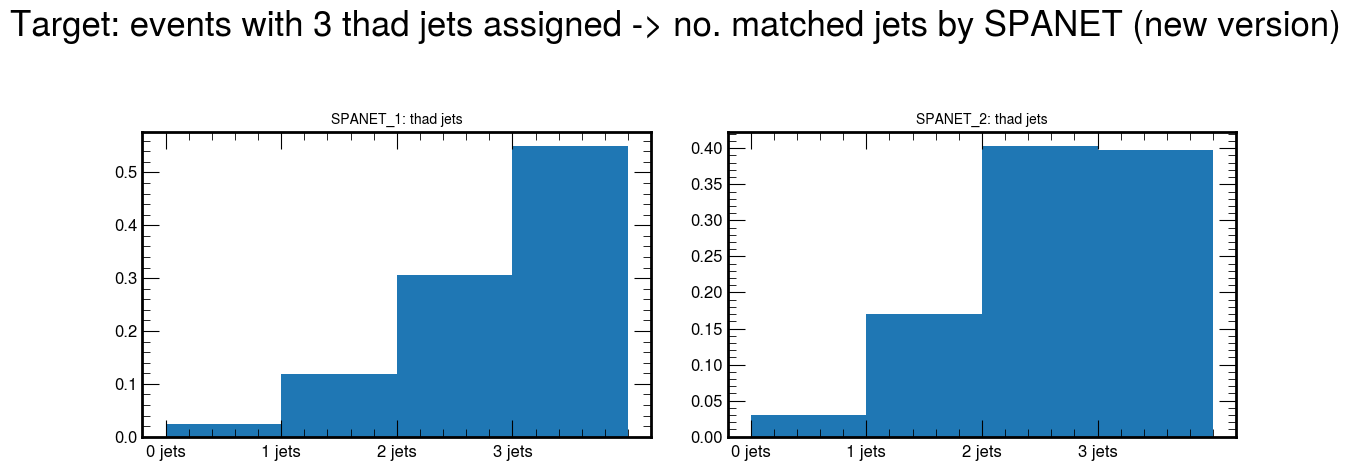

In [218]:
# SPANET VS SPANET_2:

no_bins = [4, 4]
no_plots = 2

fig, ax = plt.subplots(1, no_plots, figsize=(12, 5))
fig.suptitle('Target: events with 3 thad jets assigned -> no. matched jets by SPANET (new version)', fontsize=25)

for i in range(no_plots):
    if i == 0:
        # SPANET: 2 jets assigned
        count_no_padding, no_matched_jets = getNo_matched_jets_intersect(spanet_positions=spanet_pos, target_positions=target_pos)
    else:
        # SPANET_2: 2 jets assigned
        count_no_padding, no_matched_jets = getNo_matched_jets_intersect(spanet_positions=spanet_pos_2, target_positions=target_pos)
    
    _ = ax[i].hist(count_no_padding, bins=no_bins[i], range=(0,no_bins[i]), density=True)

    # Set number of ticks for x-axis
    # now, define the ticks (i.e. locations where the labels will be plotted)
    xticks = [j for j in range(no_bins[i])]
    ax[i].set_xticks(xticks)
    
    # also define the labels we'll use (note this MUST have the same size as `xticks`!)
    xtick_labels = [f'{j} jets' for j in range(no_bins[i])]

    # Set ticks labels for x-axis
    ax[i].set_xticklabels(xtick_labels, rotation='horizontal', fontsize=12)
    ax[i].yaxis.set_tick_params(labelsize=12)
    
    ax[i].set_title(f'SPANET_{i+1}: thad jets', fontsize=10)
    
plt.tight_layout()

# 2 thad jets

In [234]:
target_pos, pos = get_positions(prov_tensor_true_train.squeeze(dim=2), events_two_thad.squeeze(dim=1),
                                particle=prov['thad'], no_jets_required=2)

# now i will get the position of the two jets assigned to thad
padding_tensor = torch.ones((target_pos.shape[0],1)) * -2
target_pos = torch.cat((target_pos, padding_tensor), dim=1)

print(prov_tensor_true_train.shape)
print(spanet_prov.shape)
print(spanet_prov_2.shape)

spanet_pos, pos = get_positions(spanet_prov, events_two_thad.squeeze(dim=1),
                                particle=prov['thad'], no_jets_required=3)

mask = spanet_pos > 15
spanet_pos[mask] = -1

spanet_pos_2, pos = get_positions(spanet_prov_2, events_two_thad.squeeze(dim=1),
                                particle=prov['thad'], no_jets_required=3)

mask = spanet_pos_2 > 15
spanet_pos_2[mask] = -1

print(spanet_pos[0:5])
print(spanet_pos_2[0:5])

torch.Size([1612912, 16, 1])
torch.Size([1612912, 22])
torch.Size([1612912, 22])
tensor([[ 0,  3, -1],
        [ 4, -1, -1],
        [ 0,  3,  4],
        [ 1,  3,  9],
        [ 2,  3,  5]])
tensor([[ 0,  3, -1],
        [ 4, -1, -1],
        [ 0,  3,  4],
        [ 1,  3,  9],
        [ 3,  5, -1]])


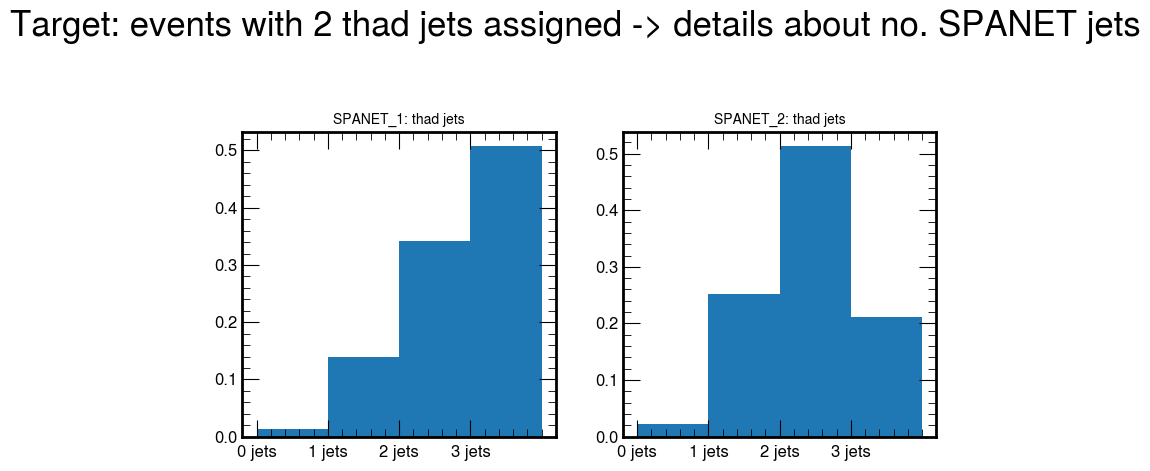

In [229]:
# STATISTICS spanet for target events with 2 Higgs jets
# SPANET VS SPANET_2

no_bins = [4, 4]
no_plots = 2

fig, ax = plt.subplots(1, no_plots, figsize=(8, 5))
fig.suptitle('Target: events with 2 thad jets assigned -> details about no. SPANET jets', fontsize=25)

for i in range(no_plots):
    no_jets_target = get_noJets_assigned2Particle(prov_tensor=spanet_prov[events_two_thad.squeeze(dim=1),:16], particle=prov['thad'])
    if i == 1:
        no_jets_target = get_noJets_assigned2Particle(prov_tensor=spanet_prov_2[events_two_thad.squeeze(dim=1),:16], particle=prov['thad'])
    
    _ = ax[i].hist(no_jets_target.numpy(), bins=no_bins[i], range=(0,no_bins[i]), density=True)

    # Set number of ticks for x-axis
    # now, define the ticks (i.e. locations where the labels will be plotted)
    xticks = [j for j in range(no_bins[i])]
    ax[i].set_xticks(xticks)
    
    # also define the labels we'll use (note this MUST have the same size as `xticks`!)
    xtick_labels = [f'{j} jets' for j in range(no_bins[i])]

    # Set ticks labels for x-axis
    ax[i].set_xticklabels(xtick_labels, rotation='horizontal', fontsize=12)
    ax[i].yaxis.set_tick_params(labelsize=12)
    
    ax[i].set_title(f'SPANET_{i+1}: thad jets', fontsize=10)
    
plt.tight_layout()

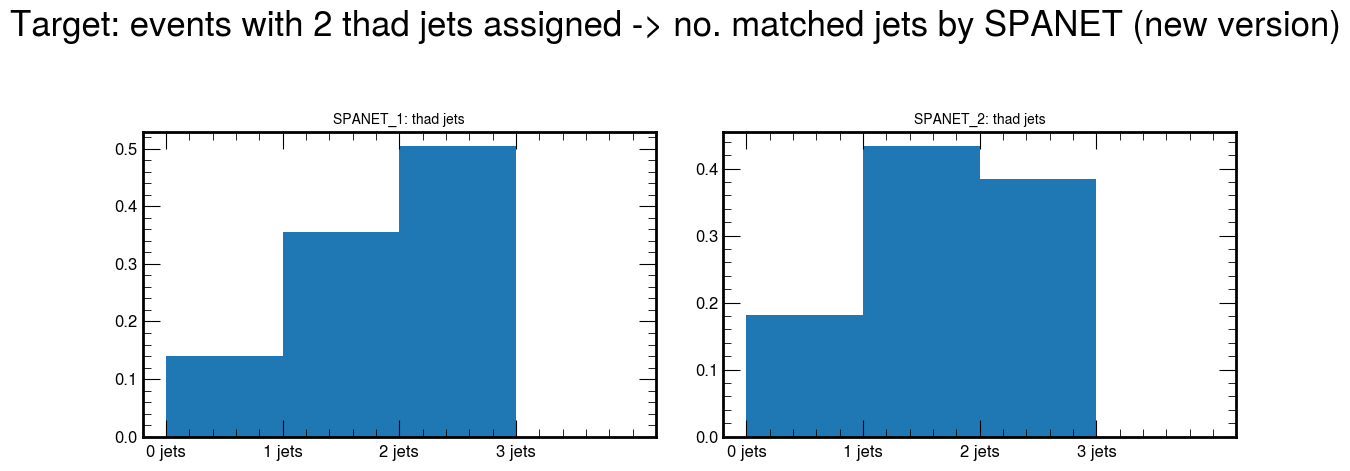

In [236]:
# SPANET VS SPANET_2:

no_bins = [4, 4]
no_plots = 2

fig, ax = plt.subplots(1, no_plots, figsize=(12, 5))
fig.suptitle('Target: events with 2 thad jets assigned -> no. matched jets by SPANET (new version)', fontsize=25)

for i in range(no_plots):
    if i == 0:
        # SPANET: 2 jets assigned
        count_no_padding, no_matched_jets = getNo_matched_jets_intersect(spanet_positions=spanet_pos[1:], target_positions=target_pos[1:])
    else:
        # SPANET_2: 2 jets assigned
        count_no_padding, no_matched_jets = getNo_matched_jets_intersect(spanet_positions=spanet_pos_2[1:], target_positions=target_pos[1:])
    
    _ = ax[i].hist(count_no_padding, bins=no_bins[i], range=(0,no_bins[i]), density=True)

    # Set number of ticks for x-axis
    # now, define the ticks (i.e. locations where the labels will be plotted)
    xticks = [j for j in range(no_bins[i])]
    ax[i].set_xticks(xticks)
    
    # also define the labels we'll use (note this MUST have the same size as `xticks`!)
    xtick_labels = [f'{j} jets' for j in range(no_bins[i])]

    # Set ticks labels for x-axis
    ax[i].set_xticklabels(xtick_labels, rotation='horizontal', fontsize=12)
    ax[i].yaxis.set_tick_params(labelsize=12)
    
    ax[i].set_title(f'SPANET_{i+1}: thad jets', fontsize=10)
    
plt.tight_layout()

# 1 thad jets

In [222]:
target_pos, pos = get_positions(prov_tensor_true_train.squeeze(dim=2), events_one_thad.squeeze(dim=1),
                                particle=prov['thad'], no_jets_required=1)

print(prov_tensor_true_train.shape)
print(spanet_prov.shape)
print(spanet_prov_2.shape)

spanet_pos, pos = get_positions(spanet_prov, events_one_thad.squeeze(dim=1),
                                particle=prov['thad'], no_jets_required=3)

mask = spanet_pos > 15
spanet_pos[mask] = -1

spanet_pos_2, pos = get_positions(spanet_prov_2, events_one_thad.squeeze(dim=1),
                                particle=prov['thad'], no_jets_required=3)

mask = spanet_pos_2 > 15
spanet_pos_2[mask] = -1

print(spanet_pos[0:5])
print(spanet_pos_2[0:5])

torch.Size([1612912, 16, 1])
torch.Size([1612912, 22])
torch.Size([1612912, 22])
tensor([[ 4, -1, -1],
        [ 0,  2, -1],
        [ 2,  3,  4],
        [ 4, -1, -1],
        [ 0,  1,  4]])
tensor([[ 4, -1, -1],
        [ 0, -1, -1],
        [ 2,  3, -1],
        [ 4, -1, -1],
        [ 0,  4, -1]])


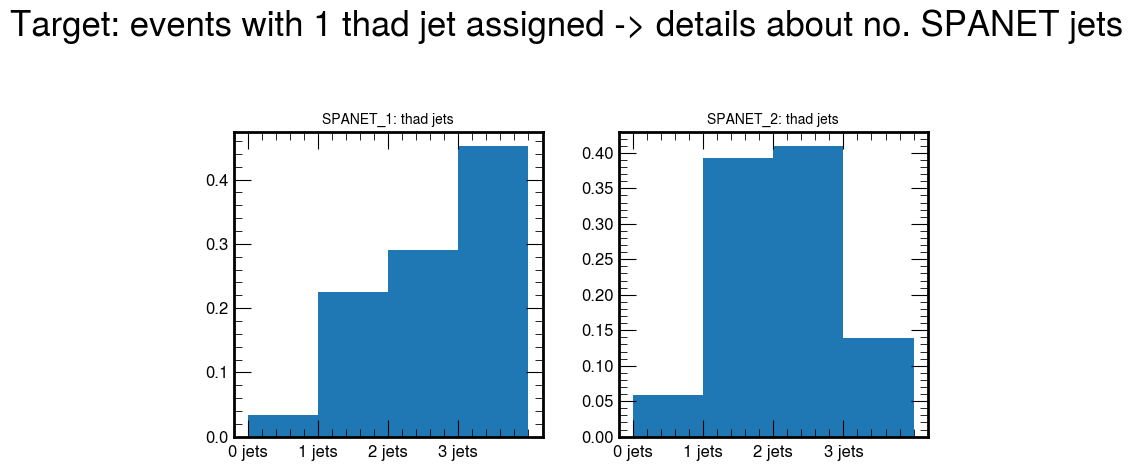

In [223]:
# STATISTICS spanet for target events with 2 Higgs jets
# SPANET VS SPANET_2

no_bins = [4, 4]
no_plots = 2

fig, ax = plt.subplots(1, no_plots, figsize=(8, 5))
fig.suptitle('Target: events with 1 thad jet assigned -> details about no. SPANET jets', fontsize=25)

for i in range(no_plots):
    no_jets_target = get_noJets_assigned2Particle(prov_tensor=spanet_prov[events_one_thad.squeeze(dim=1),:16], particle=prov['thad'])
    if i == 1:
        no_jets_target = get_noJets_assigned2Particle(prov_tensor=spanet_prov_2[events_one_thad.squeeze(dim=1),:16], particle=prov['thad'])
    
    _ = ax[i].hist(no_jets_target.numpy(), bins=no_bins[i], range=(0,no_bins[i]), density=True)

    # Set number of ticks for x-axis
    # now, define the ticks (i.e. locations where the labels will be plotted)
    xticks = [j for j in range(no_bins[i])]
    ax[i].set_xticks(xticks)
    
    # also define the labels we'll use (note this MUST have the same size as `xticks`!)
    xtick_labels = [f'{j} jets' for j in range(no_bins[i])]

    # Set ticks labels for x-axis
    ax[i].set_xticklabels(xtick_labels, rotation='horizontal', fontsize=12)
    ax[i].yaxis.set_tick_params(labelsize=12)
    
    ax[i].set_title(f'SPANET_{i+1}: thad jets', fontsize=10)
    
plt.tight_layout()

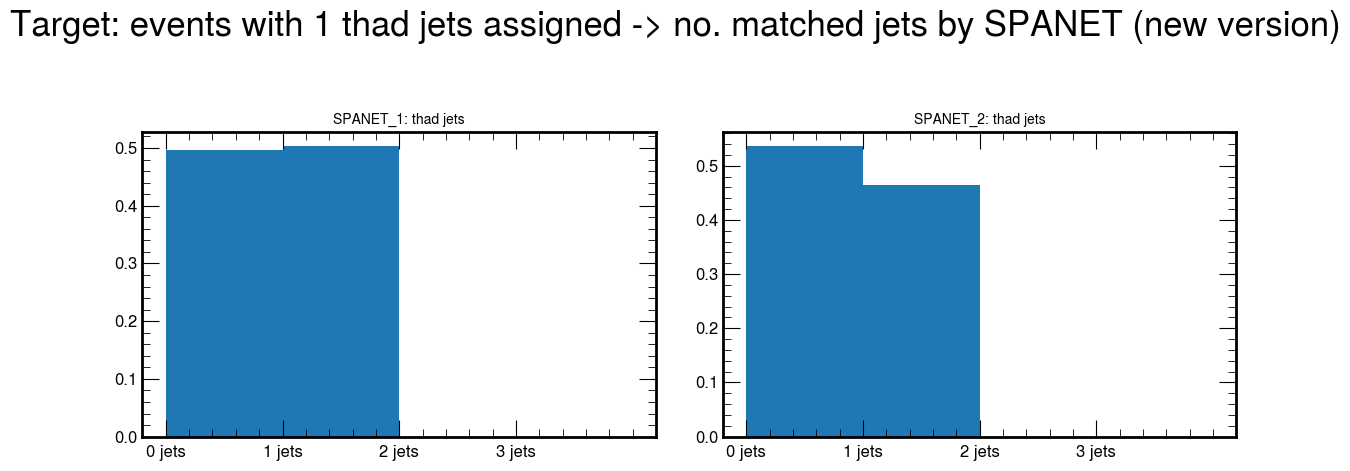

In [224]:
# SPANET VS SPANET_2:

no_bins = [4, 4]
no_plots = 2

fig, ax = plt.subplots(1, no_plots, figsize=(12, 5))
fig.suptitle('Target: events with 1 thad jets assigned -> no. matched jets by SPANET (new version)', fontsize=25)

for i in range(no_plots):
    if i == 0:
        # SPANET: 2 jets assigned
        count_no_padding, no_matched_jets = getNo_matched_jets_intersect(spanet_positions=spanet_pos, target_positions=target_pos)
    else:
        # SPANET_2: 2 jets assigned
        count_no_padding, no_matched_jets = getNo_matched_jets_intersect(spanet_positions=spanet_pos_2, target_positions=target_pos)
    
    _ = ax[i].hist(count_no_padding, bins=no_bins[i], range=(0,no_bins[i]), density=True)

    # Set number of ticks for x-axis
    # now, define the ticks (i.e. locations where the labels will be plotted)
    xticks = [j for j in range(no_bins[i])]
    ax[i].set_xticks(xticks)
    
    # also define the labels we'll use (note this MUST have the same size as `xticks`!)
    xtick_labels = [f'{j} jets' for j in range(no_bins[i])]

    # Set ticks labels for x-axis
    ax[i].set_xticklabels(xtick_labels, rotation='horizontal', fontsize=12)
    ax[i].yaxis.set_tick_params(labelsize=12)
    
    ax[i].set_title(f'SPANET_{i+1}: thad jets', fontsize=10)
    
plt.tight_layout()

# 0 thad jets

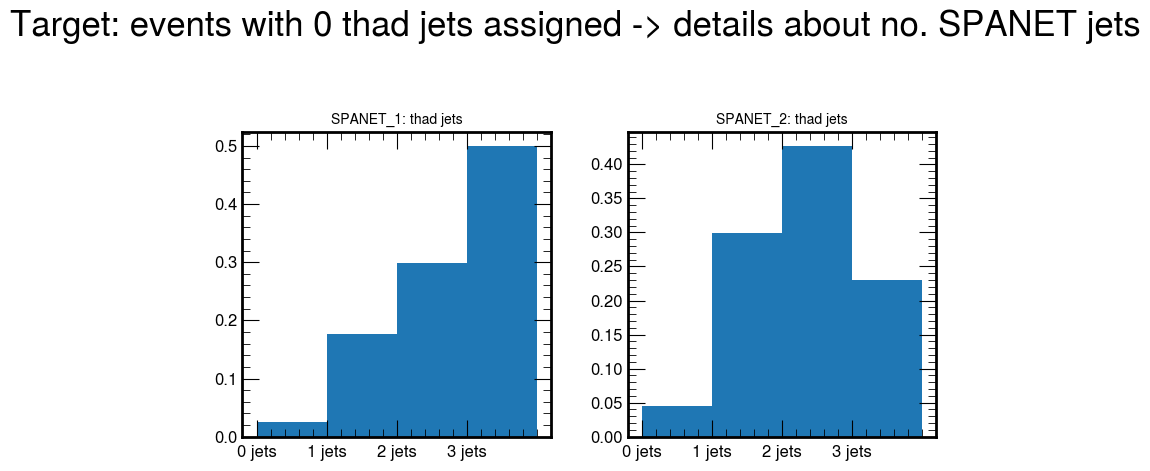

In [225]:
# STATISTICS spanet for target events with 2 Higgs jets
# SPANET VS SPANET_2

no_bins = [4, 4]
no_plots = 2

fig, ax = plt.subplots(1, no_plots, figsize=(8, 5))
fig.suptitle('Target: events with 0 thad jets assigned -> details about no. SPANET jets', fontsize=25)

for i in range(no_plots):
    no_jets_target = get_noJets_assigned2Particle(prov_tensor=spanet_prov[events_zero_thad.squeeze(dim=1),:16], particle=prov['thad'])
    if i == 1:
        no_jets_target = get_noJets_assigned2Particle(prov_tensor=spanet_prov_2[events_zero_thad.squeeze(dim=1),:16], particle=prov['thad'])
    
    _ = ax[i].hist(no_jets_target.numpy(), bins=no_bins[i], range=(0,no_bins[i]), density=True)

    # Set number of ticks for x-axis
    # now, define the ticks (i.e. locations where the labels will be plotted)
    xticks = [j for j in range(no_bins[i])]
    ax[i].set_xticks(xticks)
    
    # also define the labels we'll use (note this MUST have the same size as `xticks`!)
    xtick_labels = [f'{j} jets' for j in range(no_bins[i])]

    # Set ticks labels for x-axis
    ax[i].set_xticklabels(xtick_labels, rotation='horizontal', fontsize=12)
    ax[i].yaxis.set_tick_params(labelsize=12)
    
    ax[i].set_title(f'SPANET_{i+1}: thad jets', fontsize=10)
    
plt.tight_layout()

# THAD INCLUSIVE DATSET

In [128]:
thad = prov_tensor_true_train == prov['thad']
events_full_thad = torch.count_nonzero(thad, dim=1) == 3
events_two_thad = torch.count_nonzero(thad, dim=1) == 2
events_one_thad = torch.count_nonzero(thad, dim=1) == 1
events_zero_thad = torch.count_nonzero(thad, dim=1) == 0

print(torch.count_nonzero(events_full_thad))
print(torch.count_nonzero(events_two_thad))
print(torch.count_nonzero(events_one_thad))
print(torch.count_nonzero(events_zero_thad))

tensor(455463)
tensor(845910)
tensor(278781)
tensor(32758)


In [129]:
thad_prov_tensor_true_train = torch.clone(prov_tensor_true_train).squeeze(dim=2)
x = torch.ones((tlep_prov_tensor_true_train.shape[0], 3)) * -1
thad_prov_tensor_true_train = torch.cat((tlep_prov_tensor_true_train, x), dim=1)
print(thad_prov_tensor_true_train.shape)

thad_prov_tensor_true_train[events_zero_thad.squeeze(dim=1), -3] = prov['thad']
thad_prov_tensor_true_train[events_zero_thad.squeeze(dim=1), -2] = prov['thad']
thad_prov_tensor_true_train[events_zero_thad.squeeze(dim=1), -1] = prov['thad']

thad_prov_tensor_true_train[events_one_thad.squeeze(dim=1), -2] = prov['thad']
thad_prov_tensor_true_train[events_one_thad.squeeze(dim=1), -1] = prov['thad']

thad_prov_tensor_true_train[events_two_thad.squeeze(dim=1), -1] = prov['thad']

torch.Size([1612912, 20])


In [130]:
full_ev = torch.ones(thad_prov_tensor_true_train.shape[0], dtype=torch.bool)

target_pos, pos = get_positions(thad_prov_tensor_true_train, full_ev, particle=prov['thad'], no_jets_required=3)

mask = target_pos > 15
target_pos[mask] = -1

spanet_pos, pos = get_positions(spanet_prov, full_ev,
                                particle=prov['thad'], no_jets_required=3)

mask = spanet_pos > 15
spanet_pos[mask] = -1

spanet_pos_2, pos = get_positions(spanet_prov_2, full_ev,
                                particle=prov['thad'], no_jets_required=3)

mask = spanet_pos_2 > 15
spanet_pos_2[mask] = -1

print(target_pos[0:5])
print(spanet_pos[0:5])
print(spanet_pos_2[0:5])

tensor([[ 2,  4,  5],
        [ 0,  2, -1],
        [ 1,  4, -1],
        [ 0,  3, -1],
        [ 3,  4, -1]])
tensor([[ 2,  4,  5],
        [ 0,  3, -1],
        [ 4, -1, -1],
        [ 0,  3,  4],
        [ 1,  3,  9]])
tensor([[ 4,  5, -1],
        [ 0,  3, -1],
        [ 4, -1, -1],
        [ 0,  3,  4],
        [ 1,  3,  9]])


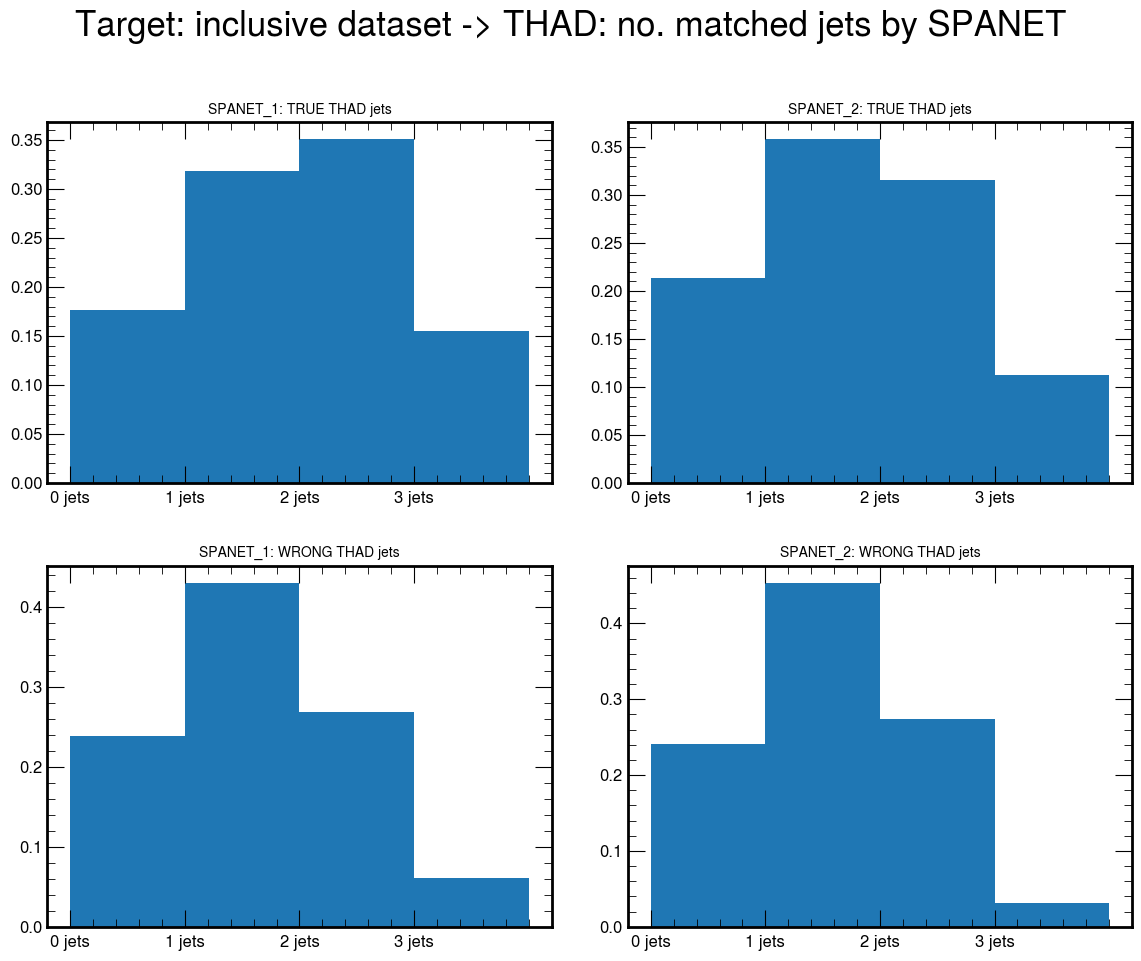

In [132]:
# Inclusive dataset

# SPANET VS SPANET_2:

no_bins = [4, 4]
no_plots = 2

fig, ax = plt.subplots(2, no_plots, figsize=(12, 10))
fig.suptitle('Target: inclusive dataset -> THAD: no. matched jets by SPANET', fontsize=25)

for i in range(no_plots):
    if i == 0:
        no_matched_jets, count_wrong, pos = getNo_matched_jets_intersect(spanet_positions=spanet_pos, target_positions=target_pos)
    else:
        no_matched_jets, count_wrong, pos = getNo_matched_jets_intersect(spanet_positions=spanet_pos_2, target_positions=target_pos)
    
    _ = ax[0,i].hist(no_matched_jets, bins=no_bins[i], range=(0,no_bins[i]), density=True)
    _ = ax[1,i].hist(count_wrong, bins=no_bins[i], range=(0,no_bins[i]), density=True)

    # Set number of ticks for x-axis
    # now, define the ticks (i.e. locations where the labels will be plotted)
    xticks = [j for j in range(no_bins[i])]
    ax[0,i].set_xticks(xticks)
    ax[1,i].set_xticks(xticks)
    
    # also define the labels we'll use (note this MUST have the same size as `xticks`!)
    xtick_labels = [f'{j} jets' for j in range(no_bins[i])]

    # Set ticks labels for x-axis
    ax[0,i].set_xticklabels(xtick_labels, rotation='horizontal', fontsize=12)
    ax[0,i].yaxis.set_tick_params(labelsize=12)
    ax[1,i].set_xticklabels(xtick_labels, rotation='horizontal', fontsize=12)
    ax[1,i].yaxis.set_tick_params(labelsize=12)
    
    ax[0,i].set_title(f'SPANET_{i+1}: TRUE THAD jets', fontsize=10)
    ax[1,i].set_title(f'SPANET_{i+1}: WRONG THAD jets', fontsize=10)
    
plt.tight_layout()